<a href="https://colab.research.google.com/github/Subtlr/breast_cancer_prediction/blob/main/breast_cancer_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data and Modules

In [1]:
!pip install opendatasets --quiet

In [2]:
import opendatasets as od

In [3]:
od.download(r"https://www.kaggle.com/datasets/wasiqaliyasir/breast-cancer-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fadlynabilliantama
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/wasiqaliyasir/breast-cancer-dataset


100%|██████████| 48.7k/48.7k [00:00<00:00, 40.7MB/s]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

plt.style.use("dark_background")

In [5]:
df_unmodified = pd.read_csv(r"/content/breast-cancer-dataset/Breast_cancer_dataset.csv")

In [6]:
df_unmodified

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


# Data Preprocessing

In [7]:
df_unmodified.drop(columns='Unnamed: 32', inplace=True)

In [8]:
df_unmodified.isna().sum()

,0
id,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0


In [9]:
X, y = df_unmodified.drop(columns=['diagnosis', 'id']), df_unmodified['diagnosis']

In [10]:
y.value_counts()["B"]

np.int64(357)

In [11]:
import imblearn as imb

In [12]:
def preprocess_data(X, y):
  smote = imb.over_sampling.SMOTE(random_state=36)
  X_resampled, y_resampled = smote.fit_resample(X, y)
  print(f"Class Amounts: {y_resampled.value_counts().iloc[0]} and {y_resampled.value_counts().iloc[1]}")

  X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=36)
  X_train, X_val, y_train, y_val = skl.model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=36)

  return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(X, y)

Class Amounts: 357 and 357


In [14]:
def standardize_data(X_train, X_val, X_test):
  scaler = skl.preprocessing.StandardScaler()

  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
  X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
  X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

  return X_train, X_val, X_test

In [15]:
X_train, X_val, X_test = standardize_data(X_train, X_val, X_test)

In [16]:
X_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.047892,-1.202470,-0.108259,-0.167332,-0.660691,-0.695740,-0.742962,-0.567757,-1.174905,-0.520292,...,-0.023525,-1.424894,-0.022368,-0.201044,-0.571090,-0.514054,-0.458838,-0.082757,0.245769,-0.187147
1,0.662271,1.116172,0.704390,0.616014,0.625058,1.165178,1.158042,0.853658,-0.388047,0.267087,...,1.152260,1.105679,1.100875,1.107655,0.592953,1.780301,1.288534,0.753668,-0.386374,1.547676
2,-0.733715,2.378237,-0.806689,-0.718406,-1.538633,-1.567263,-1.338654,-1.449080,-0.489507,-0.446544,...,-0.777416,1.941083,-0.854736,-0.734677,-1.824991,-1.473248,-1.515787,-1.962082,-0.897970,-0.993428
3,0.125777,-0.395878,0.075197,0.025365,-1.086966,-0.772314,-0.601100,-0.600034,-0.995748,-0.867214,...,0.090407,0.017307,0.049269,-0.021669,-0.362159,-0.204205,-0.170455,-0.409043,0.085400,-0.217418
4,1.287485,0.141422,1.272961,1.249082,0.878791,0.838997,1.332316,1.676590,0.605699,-0.328392,...,1.244951,0.112199,1.085476,1.188704,0.543209,0.818062,0.927272,1.506796,0.884015,0.177472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,-0.144293,-0.029277,-0.061830,-0.215310,-0.748784,1.090263,0.422051,0.200154,-0.440006,1.446321,...,-0.319555,-0.722255,-0.379669,-0.389200,-1.571774,-0.215535,-0.424934,-0.428277,-1.121816,0.154574
424,1.552362,-0.490090,1.413879,1.614375,-0.960057,-0.679034,-0.215267,0.303824,-0.066845,-0.896714,...,1.500046,-0.508117,1.252480,1.581380,-0.489843,-0.606253,-0.328624,0.832118,-0.340806,0.212085
425,-0.350866,-1.106075,-0.372422,-0.406140,-1.113847,-0.741882,-0.789371,-0.831804,-0.143000,-0.543338,...,-0.562300,-1.138819,-0.486573,-0.572051,-0.322837,0.191946,-0.253443,-0.378702,0.699997,0.623043
426,-0.681383,0.984042,-0.544528,-0.689944,1.567760,2.522248,1.599733,0.685032,0.763248,3.061095,...,-0.453756,2.381069,-0.495434,-0.481868,2.286073,5.012092,3.913912,1.357908,2.299597,6.827614


<Axes: >

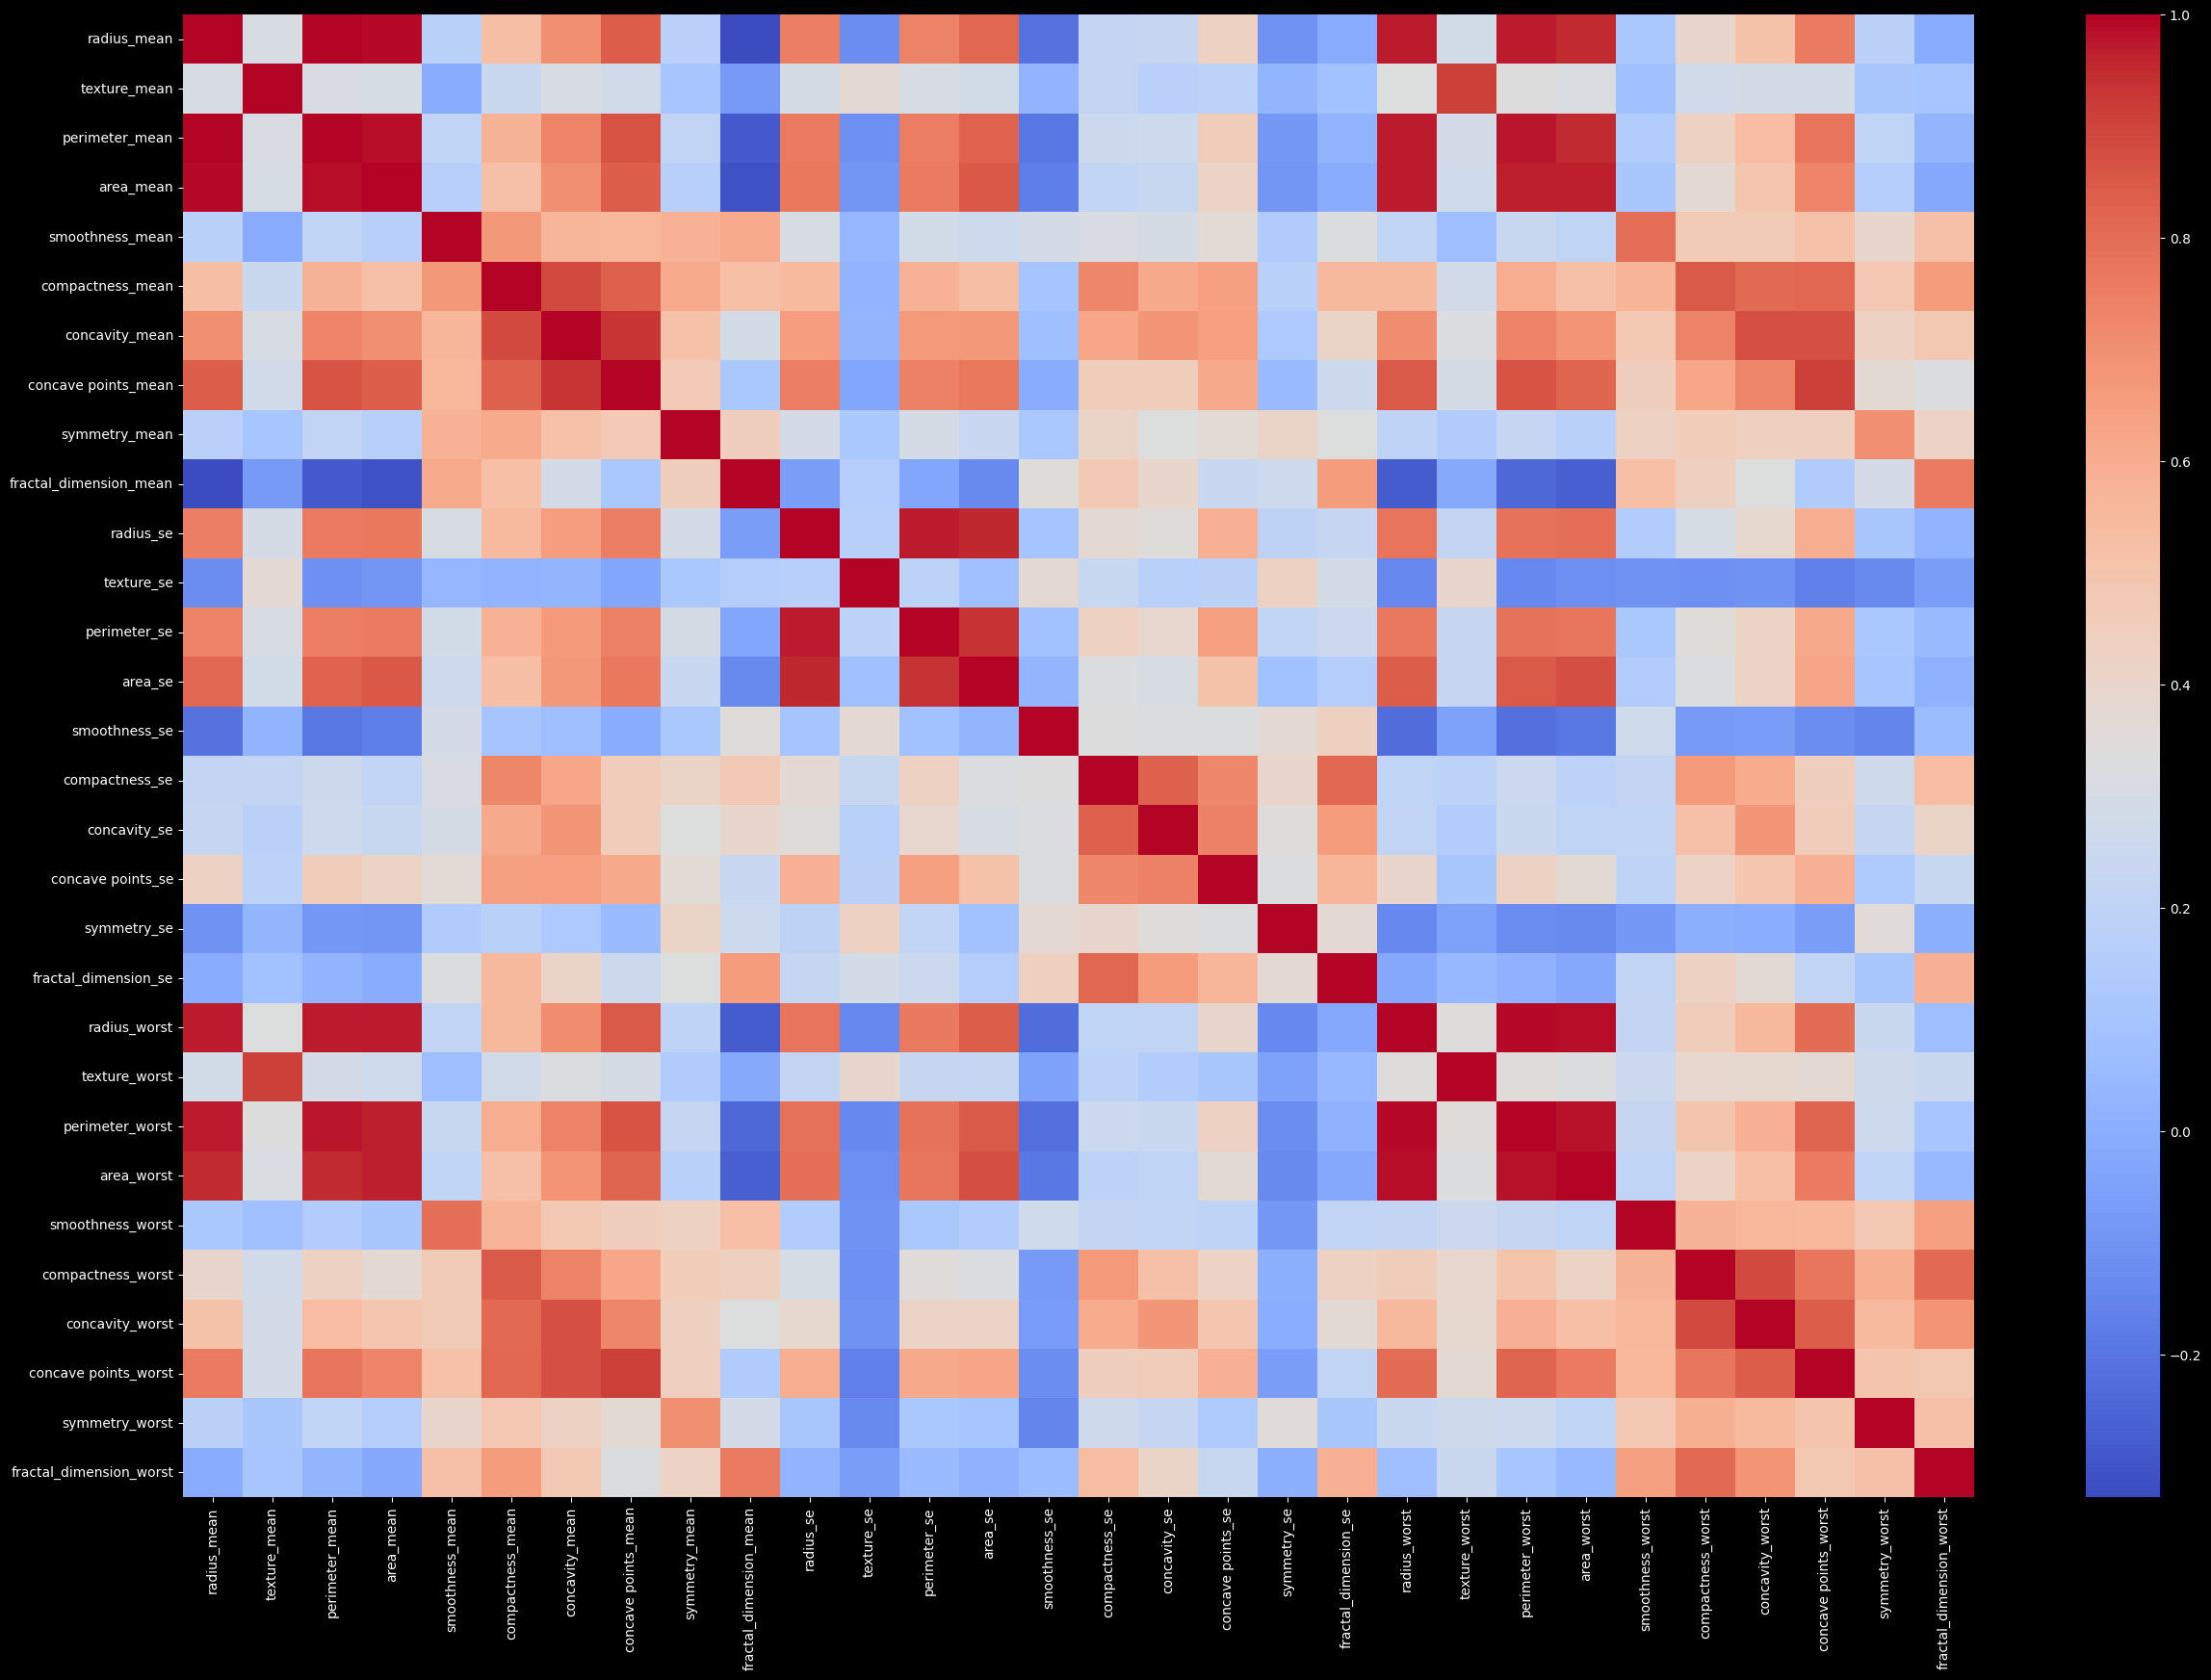

In [17]:
plt.figure(figsize=(30,20))
sns.heatmap(X_train.corr(), cmap="coolwarm")

In [18]:
def combine_3_features(X_train, X_val, X_test, col1, col2, col3, delete:bool):
  X_train[f'{col1}_{col2}_{col3}_mean'] = X_train[[col1, col2, col3]].mean(axis=1)
  X_val[f'{col1}_{col2}_{col3}_mean'] = X_val[[col1, col2, col3]].mean(axis=1)
  X_test[f'{col1}_{col2}_{col3}_mean'] = X_test[[col1, col2, col3]].mean(axis=1)

  if delete == True:
    X_train.drop(columns=[col1, col2, col3], inplace=True)
    X_val.drop(columns=[col1, col2, col3], inplace=True)
    X_test.drop(columns=[col1, col2, col3], inplace=True)
  else: pass

  return X_train, X_val, X_test

In [19]:
X_train, X_val, X_test = combine_3_features(X_train, X_val, X_test, 'radius_mean', 'perimeter_mean', 'area_mean', delete=True)
X_train, X_val, X_test = combine_3_features(X_train, X_val, X_test, 'radius_worst', 'perimeter_worst', 'area_worst', delete=True)

In [20]:
rename_hash = {
    "radius_mean_perimeter_mean_area_mean_mean": "rpa_mean",
    "radius_worst_perimeter_worst_area_worst_mean": "rpa_worst"
}

In [21]:
X_train.rename(columns=rename_hash, inplace=True)
X_val.rename(columns=rename_hash, inplace=True)
X_test.rename(columns=rename_hash, inplace=True)

In [22]:
X_train

,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,...,fractal_dimension_se,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,rpa_mean,rpa_worst
0,-1.202470,-0.660691,-0.695740,-0.742962,-0.567757,-1.174905,-0.520292,-0.369461,-1.479599,-0.300380,...,-0.455844,-1.424894,-0.571090,-0.514054,-0.458838,-0.082757,0.245769,-0.187147,-0.107828,-0.082312
1,1.116172,0.625058,1.165178,1.158042,0.853658,-0.388047,0.267087,1.526609,0.036734,1.294795,...,0.880989,1.105679,0.592953,1.780301,1.288534,0.753668,-0.386374,1.547676,0.660892,1.120264
2,2.378237,-1.538633,-1.567263,-1.338654,-1.449080,-0.489507,-0.446544,0.017857,4.441535,-0.117657,...,-0.293778,1.941083,-1.824991,-1.473248,-1.515787,-1.962082,-0.897970,-0.993428,-0.752937,-0.788943
3,-0.395878,-1.086966,-0.772314,-0.601100,-0.600034,-0.995748,-0.867214,-0.725863,-0.904538,-0.724766,...,-0.800201,0.017307,-0.362159,-0.204205,-0.170455,-0.409043,0.085400,-0.217418,0.075447,0.039336
4,0.141422,0.878791,0.838997,1.332316,1.676590,0.605699,-0.328392,0.928210,-0.401164,0.613916,...,0.161038,0.112199,0.543209,0.818062,0.927272,1.506796,0.884015,0.177472,1.269842,1.173044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,-0.029277,-0.748784,1.090263,0.422051,0.200154,-0.440006,1.446321,1.660658,1.020695,0.659571,...,8.761722,-0.722255,-1.571774,-0.215535,-0.424934,-0.428277,-1.121816,0.154574,-0.140478,-0.362808
424,-0.490090,-0.960057,-0.679034,-0.215267,0.303824,-0.066845,-0.896714,0.387449,-0.867602,0.153003,...,-0.111970,-0.508117,-0.489843,-0.606253,-0.328624,0.832118,-0.340806,0.212085,1.526872,1.444635
425,-1.106075,-1.113847,-0.741882,-0.789371,-0.831804,-0.143000,-0.543338,-1.133537,-1.217887,-1.056546,...,0.501402,-1.138819,-0.322837,0.191946,-0.253443,-0.378702,0.699997,0.623043,-0.376476,-0.540308
426,0.984042,1.567760,2.522248,1.599733,0.685032,0.763248,3.061095,-0.539927,0.709046,-0.562616,...,2.894287,2.381069,2.286073,5.012092,3.913912,1.357908,2.299597,6.827614,-0.638619,-0.477019


<Axes: >

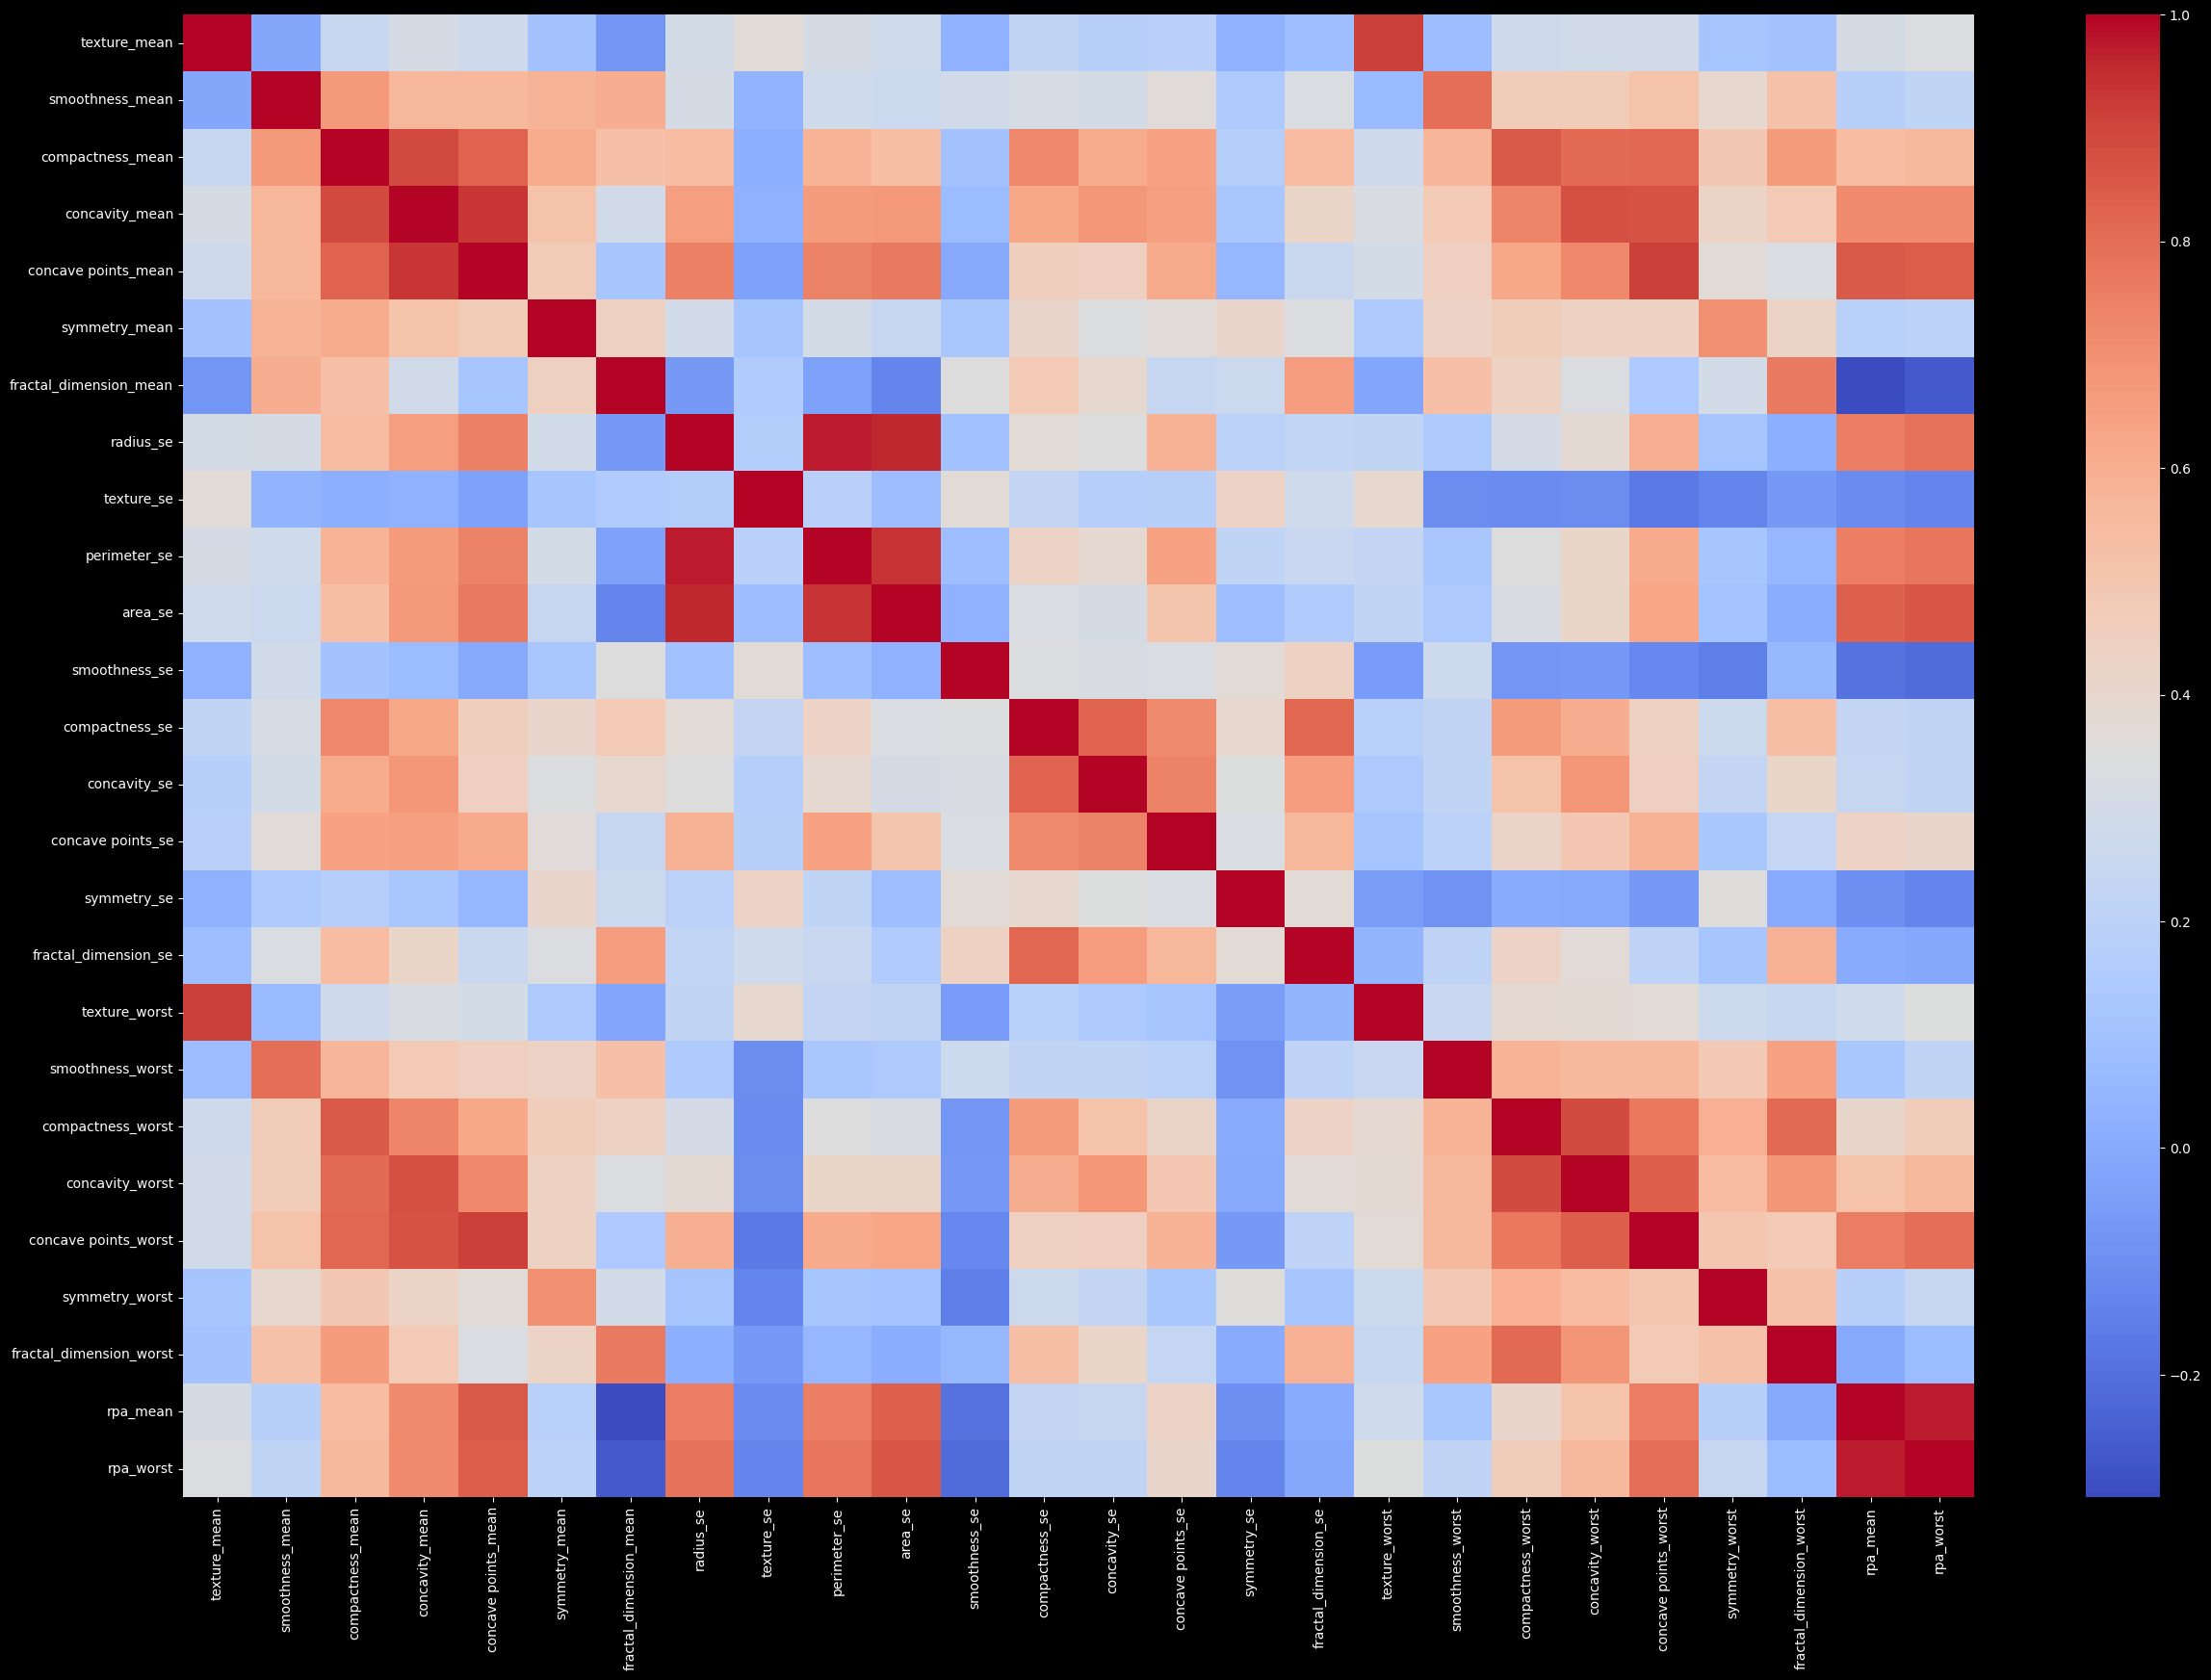

In [23]:
plt.figure(figsize=(30,20))
sns.heatmap(X_train.corr(), cmap="coolwarm")

# Machine Learning

## Logistic Regression

In [24]:
X_train.shape

(428, 26)

In [25]:
logistician = skl.linear_model.LogisticRegressionCV(cv=5, scoring="recall", verbose=True)

In [26]:
logistician.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


LogisticRegressionCV(cv=5, scoring='recall', verbose=True)

In [27]:
log_y_preds = logistician.predict(X_val)
log_y_probas = logistician.predict_proba(X_val)

In [28]:
log_betas = pd.DataFrame(logistician.coef_, columns=X_train.columns)
log_betas.head()

,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,...,fractal_dimension_se,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,rpa_mean,rpa_worst
0,-0.227853,1.824699,0.570521,1.594251,1.274648,-0.174642,-0.830313,2.865281,-1.666869,0.380631,...,-3.698181,4.025254,-1.679886,-0.138317,1.977065,2.407697,3.213778,2.495139,1.684053,5.269556


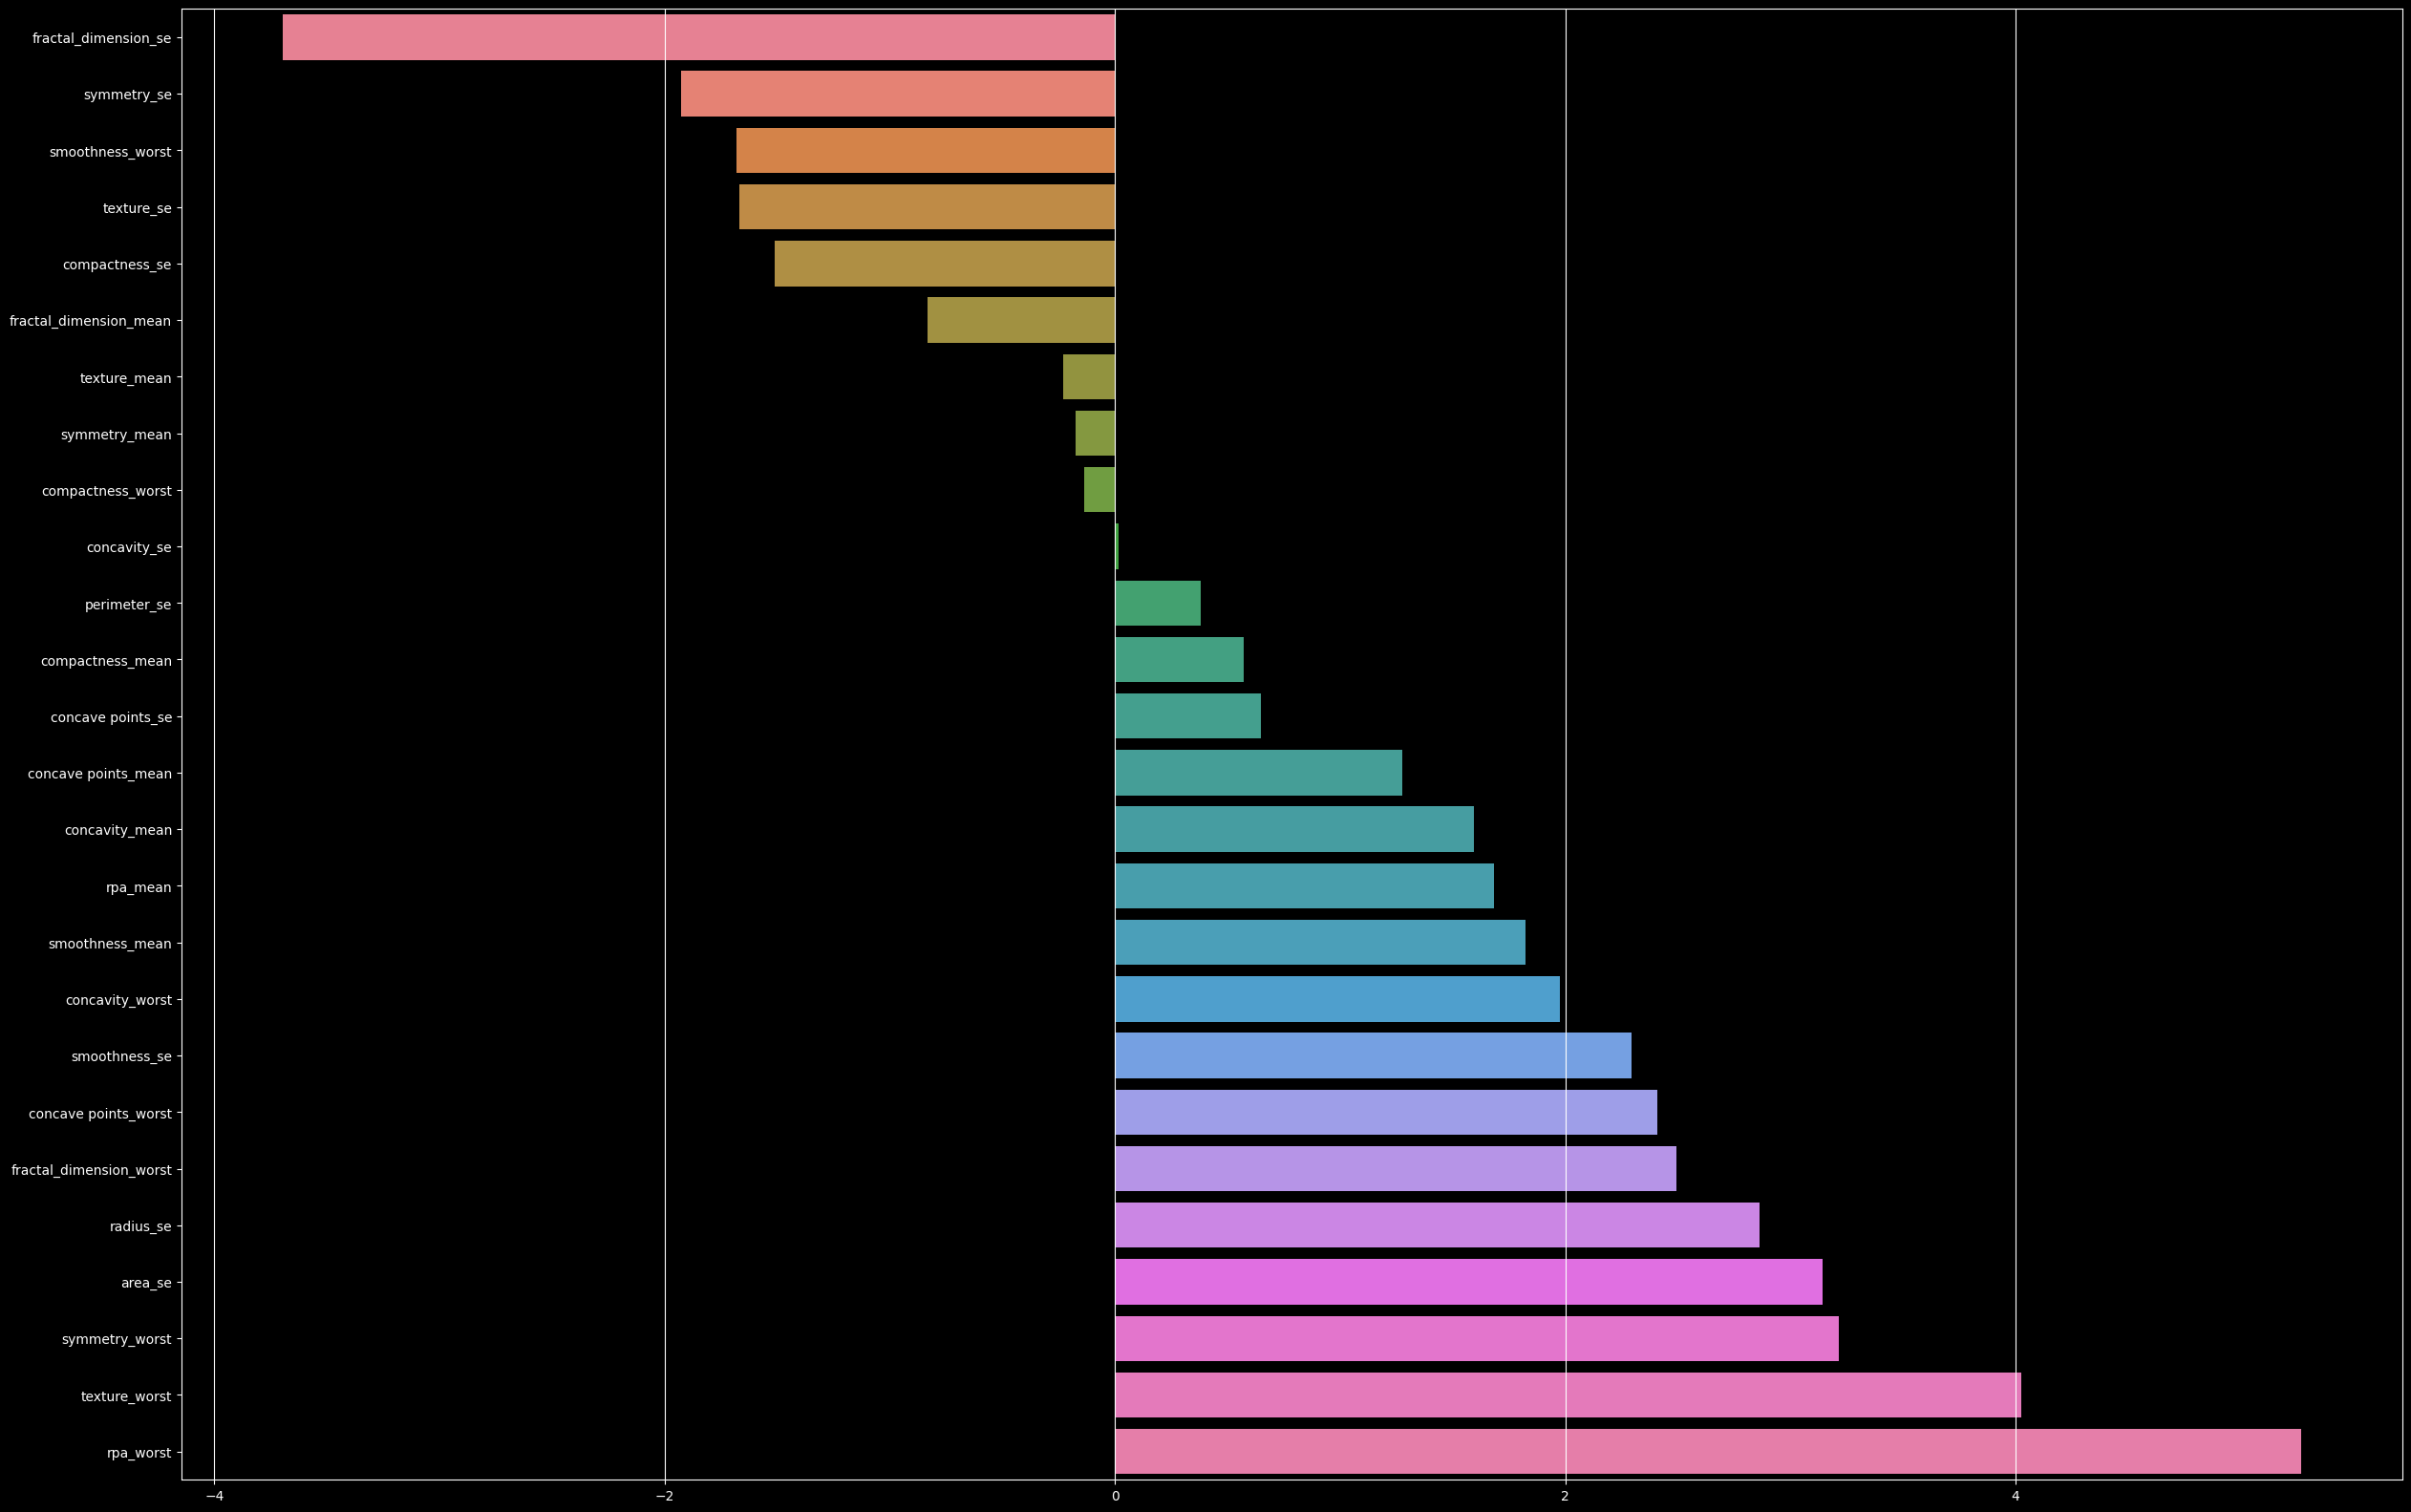

In [29]:
plt.figure(figsize=(30,20))
sns.barplot(data=log_betas.sort_values(by=0, axis=1), orient="h")
plt.grid(axis="x", c="white")
plt.show()

In [30]:
def model_evaluation(y_val, y_preds, y_probas):

  # Evaluate the model on the validation set
  log_precision = skl.metrics.precision_score(y_val, y_preds, pos_label='B') # Assuming 'M' is the positive class
  log_recall = skl.metrics.recall_score(y_val, y_preds, pos_label='B')
  log_f1 = skl.metrics.f1_score(y_val, y_preds, pos_label='B')
  log_bceloss = skl.metrics.log_loss(y_val, y_probas)

  print(f"Validation Precision: {log_precision:.4f}")
  print(f"Validation Recall: {log_recall:.4f}")
  print(f"Validation F1-score: {log_f1:.4f}")
  print(f"Validation BinaryCrossEntropy Loss: {log_bceloss:.4f}")

  # Display confusion matrix
  log_conf_matrix = skl.metrics.confusion_matrix(y_val, y_preds, labels=['M', 'B'])
  print("\nConfusion Matrix:")
  print(log_conf_matrix) # Specify labels to ensure correct order

  # Display classification report
  print("\nClassification Report:")
  print(skl.metrics.classification_report(y_val, y_preds))

  return log_conf_matrix

In [31]:
log_conf_matrix = model_evaluation(y_val, log_y_preds, log_y_probas)

Validation Precision: 0.9865
Validation Recall: 0.9865
Validation F1-score: 0.9865
Validation BinaryCrossEntropy Loss: 0.0346

Confusion Matrix:
[[68  1]
 [ 1 73]]

Classification Report:
              precision    recall  f1-score   support

           B       0.99      0.99      0.99        74
           M       0.99      0.99      0.99        69

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



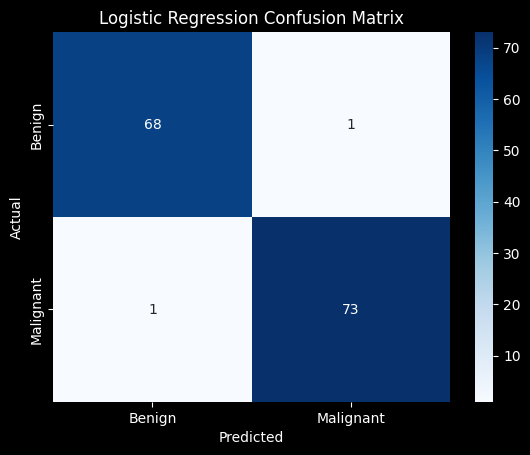

In [32]:
sns.heatmap(log_conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xticks([0.5, 1.5], ['Benign', 'Malignant'])
plt.yticks([0.5, 1.5], ['Benign', 'Malignant'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

## Random Forests

In [33]:
forest = skl.ensemble.RandomForestClassifier(n_estimators=50, max_leaf_nodes=40, max_depth=4, verbose=1, n_jobs=-1, class_weight='balanced')

In [34]:
forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


RandomForestClassifier(class_weight='balanced', max_depth=4, max_leaf_nodes=40,
                       n_estimators=50, n_jobs=-1, verbose=1)

In [35]:
forest_y_preds = forest.predict(X_val)
forest_y_probas = forest.predict_proba(X_val)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [36]:
forest_y_preds

array(['B', 'B', 'M', 'M', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'M', 'M',
       'M', 'B', 'B', 'M', 'B', 'M', 'M', 'M', 'M', 'B', 'M', 'M', 'M',
       'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'M', 'M', 'M', 'M',
       'B', 'B', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'M',
       'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M',
       'M', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'B',
       'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'M',
       'B', 'M', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'M', 'B', 'B', 'B',
       'M', 'B', 'M', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'M', 'M', 'B', 'M',
       'B', 'M', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'B', 'M', 'M'],
      dtype=object)

In [37]:
y_val.values

array(['B', 'B', 'M', 'M', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'M', 'M',
       'M', 'B', 'B', 'M', 'B', 'M', 'M', 'M', 'M', 'B', 'M', 'M', 'M',
       'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'M', 'M', 'M', 'M',
       'B', 'B', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'M',
       'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M',
       'M', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'B',
       'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'M', 'B', 'B', 'B',
       'M', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'M', 'M', 'B', 'M',
       'B', 'M', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'B', 'B', 'M'],
      dtype=object)

In [38]:
forest_conf_matrix = model_evaluation(y_val, forest_y_preds, forest_y_probas)

Validation Precision: 1.0000
Validation Recall: 0.9324
Validation F1-score: 0.9650
Validation BinaryCrossEntropy Loss: 0.1159

Confusion Matrix:
[[69  0]
 [ 5 69]]

Classification Report:
              precision    recall  f1-score   support

           B       1.00      0.93      0.97        74
           M       0.93      1.00      0.97        69

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



In [39]:
def confusion_matrix_heatmap(conf_matrix, title:str):
  sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
  plt.xticks([0.5, 1.5], ['Good', 'Bad'])
  plt.yticks([0.5, 1.5], ['Good', 'Bad'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title(title)
  plt.show()

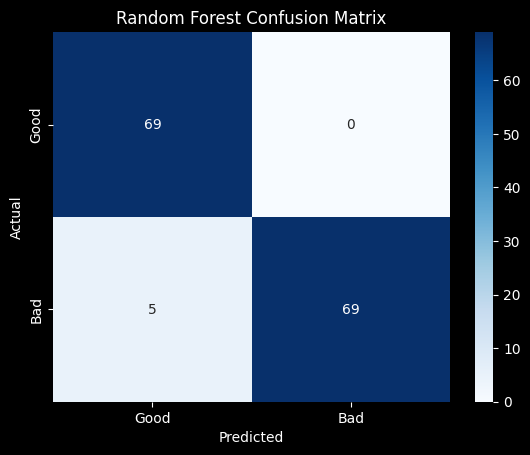

In [40]:
confusion_matrix_heatmap(forest_conf_matrix, "Random Forest Confusion Matrix")

In [41]:
forest_betas = pd.DataFrame(forest.feature_importances_, index=X_train.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)

In [42]:
forest_betas.T

,concave points_worst,concave points_mean,rpa_worst,rpa_mean,concavity_worst,area_se,perimeter_se,concavity_mean,compactness_mean,compactness_worst,...,smoothness_worst,fractal_dimension_worst,fractal_dimension_mean,compactness_se,concave points_se,symmetry_se,fractal_dimension_se,symmetry_mean,smoothness_se,texture_se
Importance,0.209054,0.175514,0.144885,0.122544,0.064318,0.043251,0.039638,0.038007,0.034699,0.024387,...,0.005104,0.004744,0.003718,0.003525,0.003448,0.002386,0.002266,0.001243,0.001166,0.001081


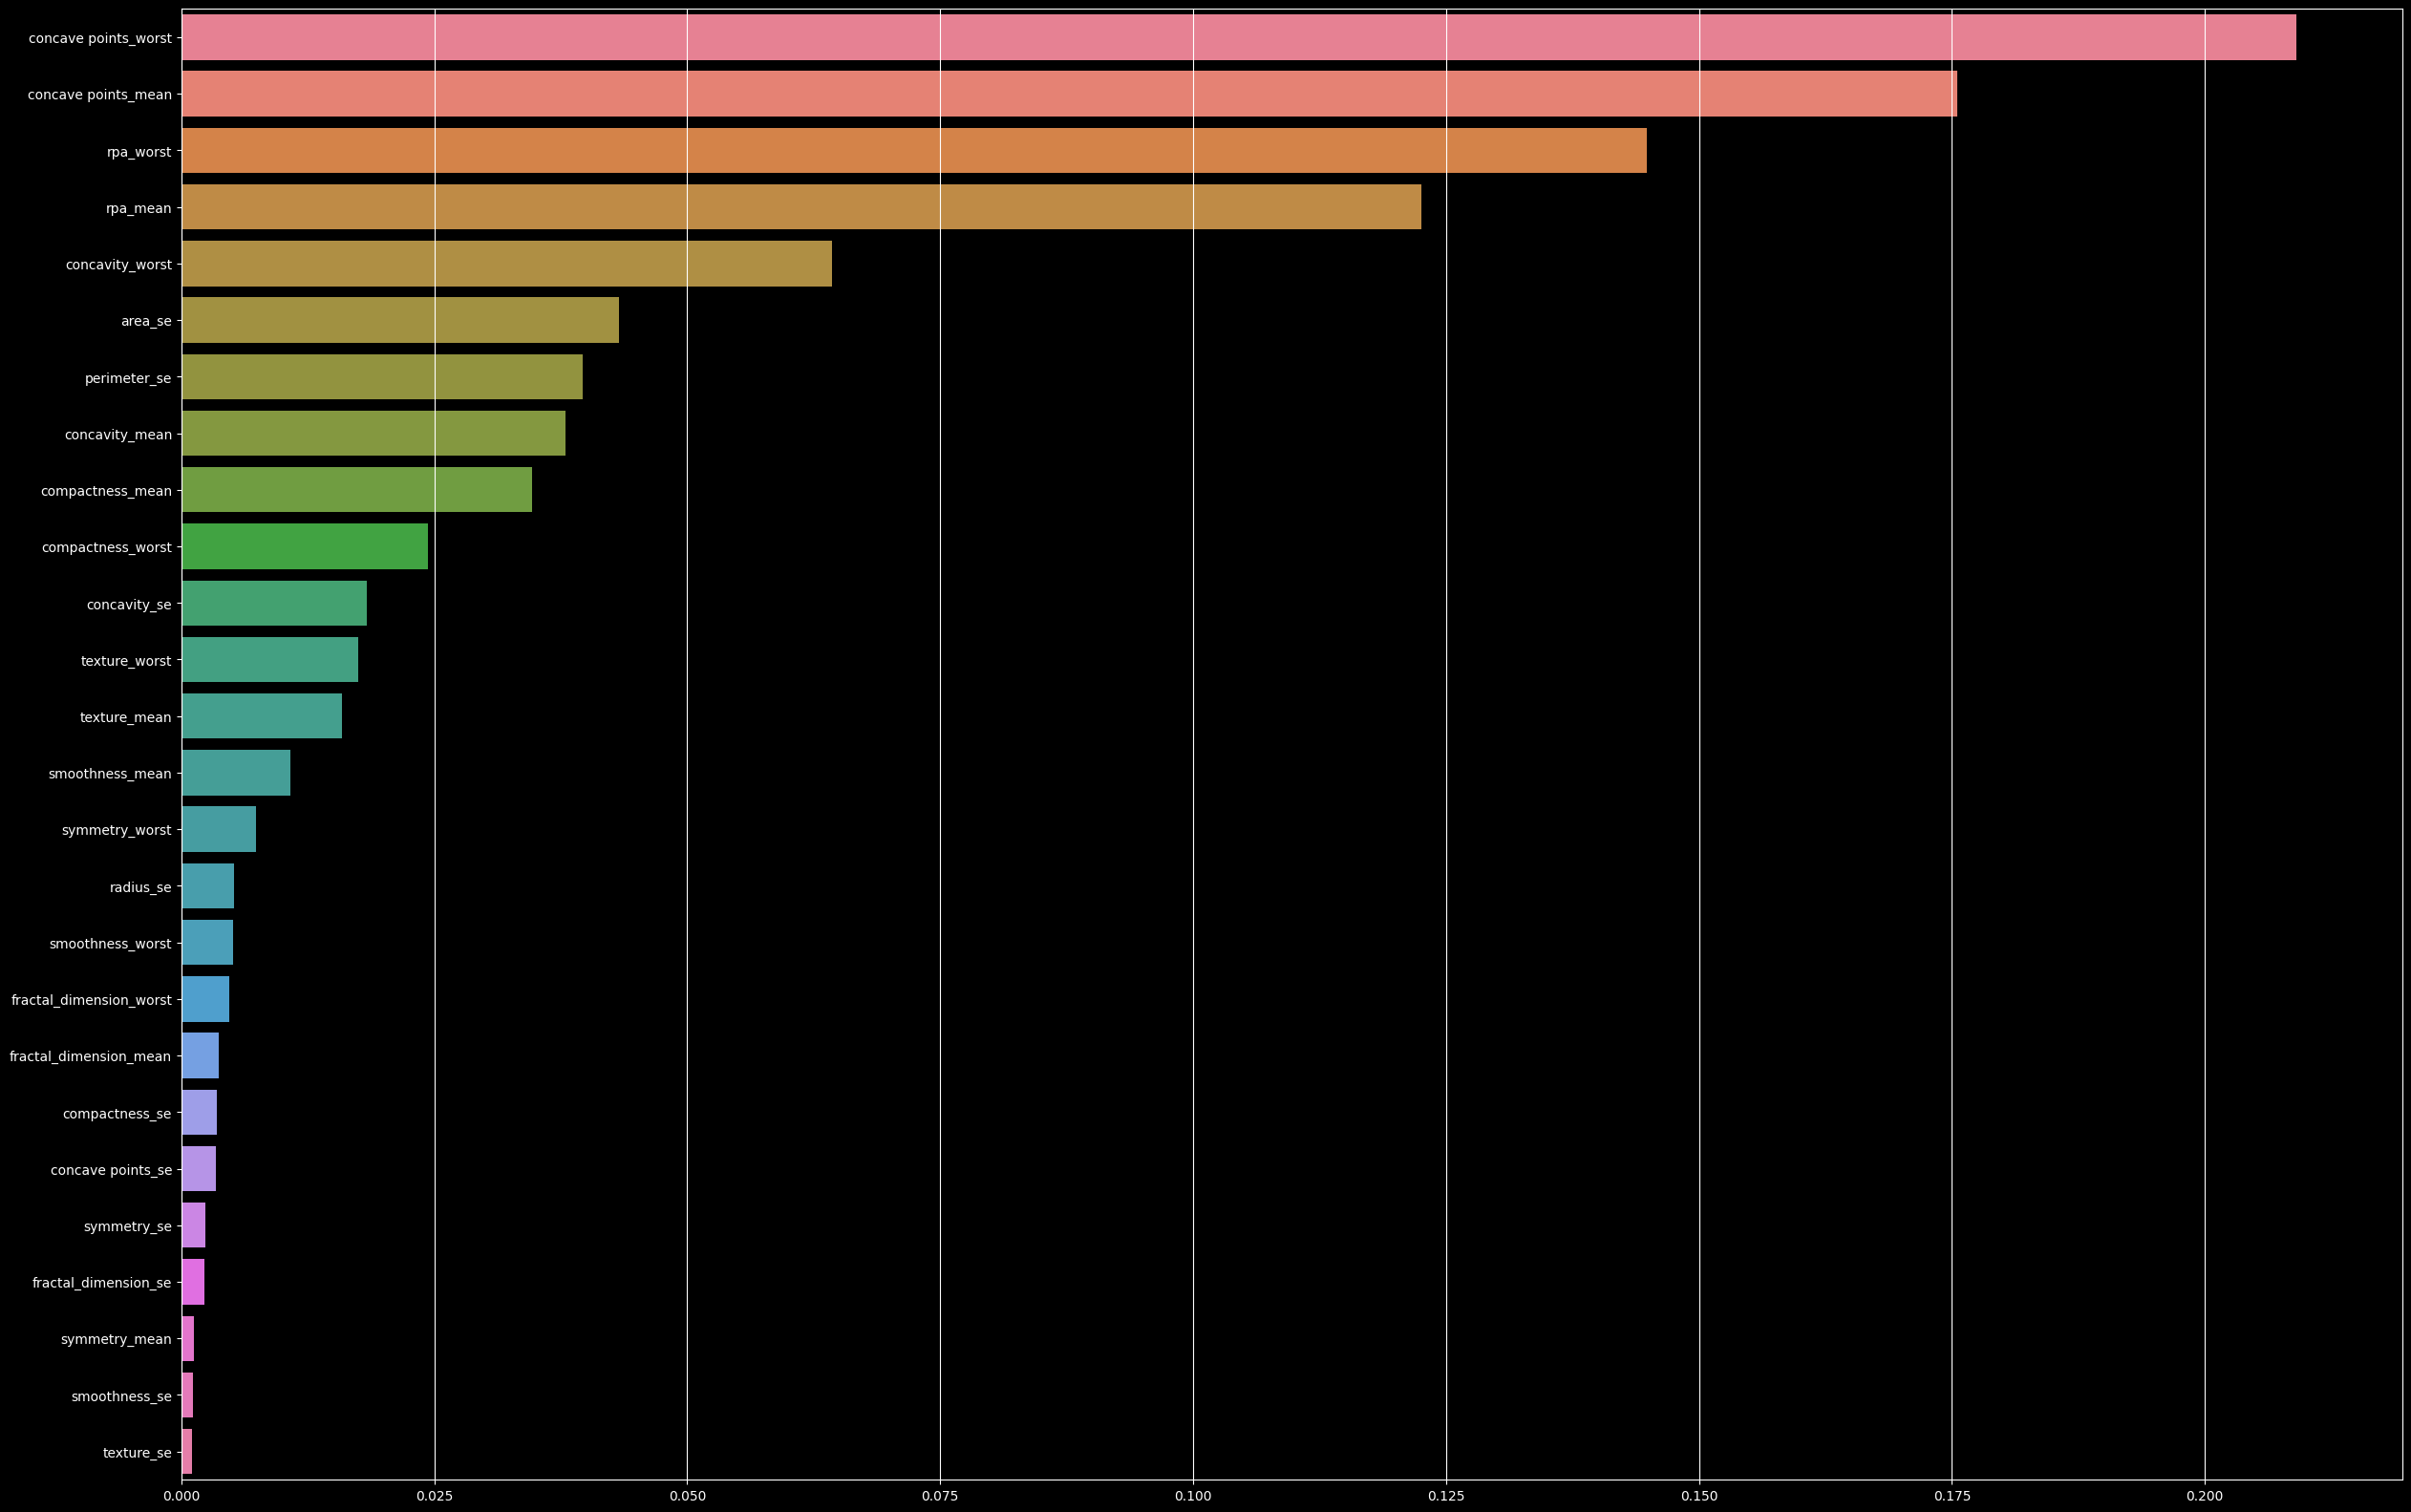

In [43]:
plt.figure(figsize=(30,20))
sns.barplot(data=forest_betas.T, orient="h")
plt.grid(axis="x", c="white")
plt.show()

## SVM

In [44]:
svm = skl.svm.SVC(kernel='linear', probability=True, verbose=True)

In [45]:
svm.fit(X_train, y_train)

[LibSVM]

SVC(kernel='linear', probability=True, verbose=True)

In [46]:
svm_y_preds = svm.predict(X_val)
svm_y_probas = svm.predict_proba(X_val)

In [47]:
svm_conv_matrix = model_evaluation(y_val, svm_y_preds, svm_y_probas)

Validation Precision: 0.9737
Validation Recall: 1.0000
Validation F1-score: 0.9867
Validation BinaryCrossEntropy Loss: 0.0478

Confusion Matrix:
[[67  2]
 [ 0 74]]

Classification Report:
              precision    recall  f1-score   support

           B       0.97      1.00      0.99        74
           M       1.00      0.97      0.99        69

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



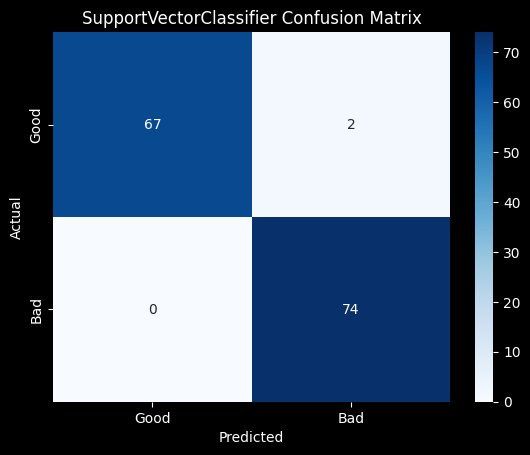

In [48]:
confusion_matrix_heatmap(svm_conv_matrix, "SupportVectorClassifier Confusion Matrix")

In [49]:
svm_betas = pd.DataFrame(svm.coef_, columns=X_train.columns)
svm_betas.head()

,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,...,fractal_dimension_se,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,rpa_mean,rpa_worst
0,0.06491,0.162856,-0.091446,0.681849,0.700359,0.146743,-0.500165,0.889561,-0.376939,0.464835,...,-0.907284,0.973089,0.02828,0.147739,0.320892,0.817679,0.720738,1.01678,0.735943,1.200516


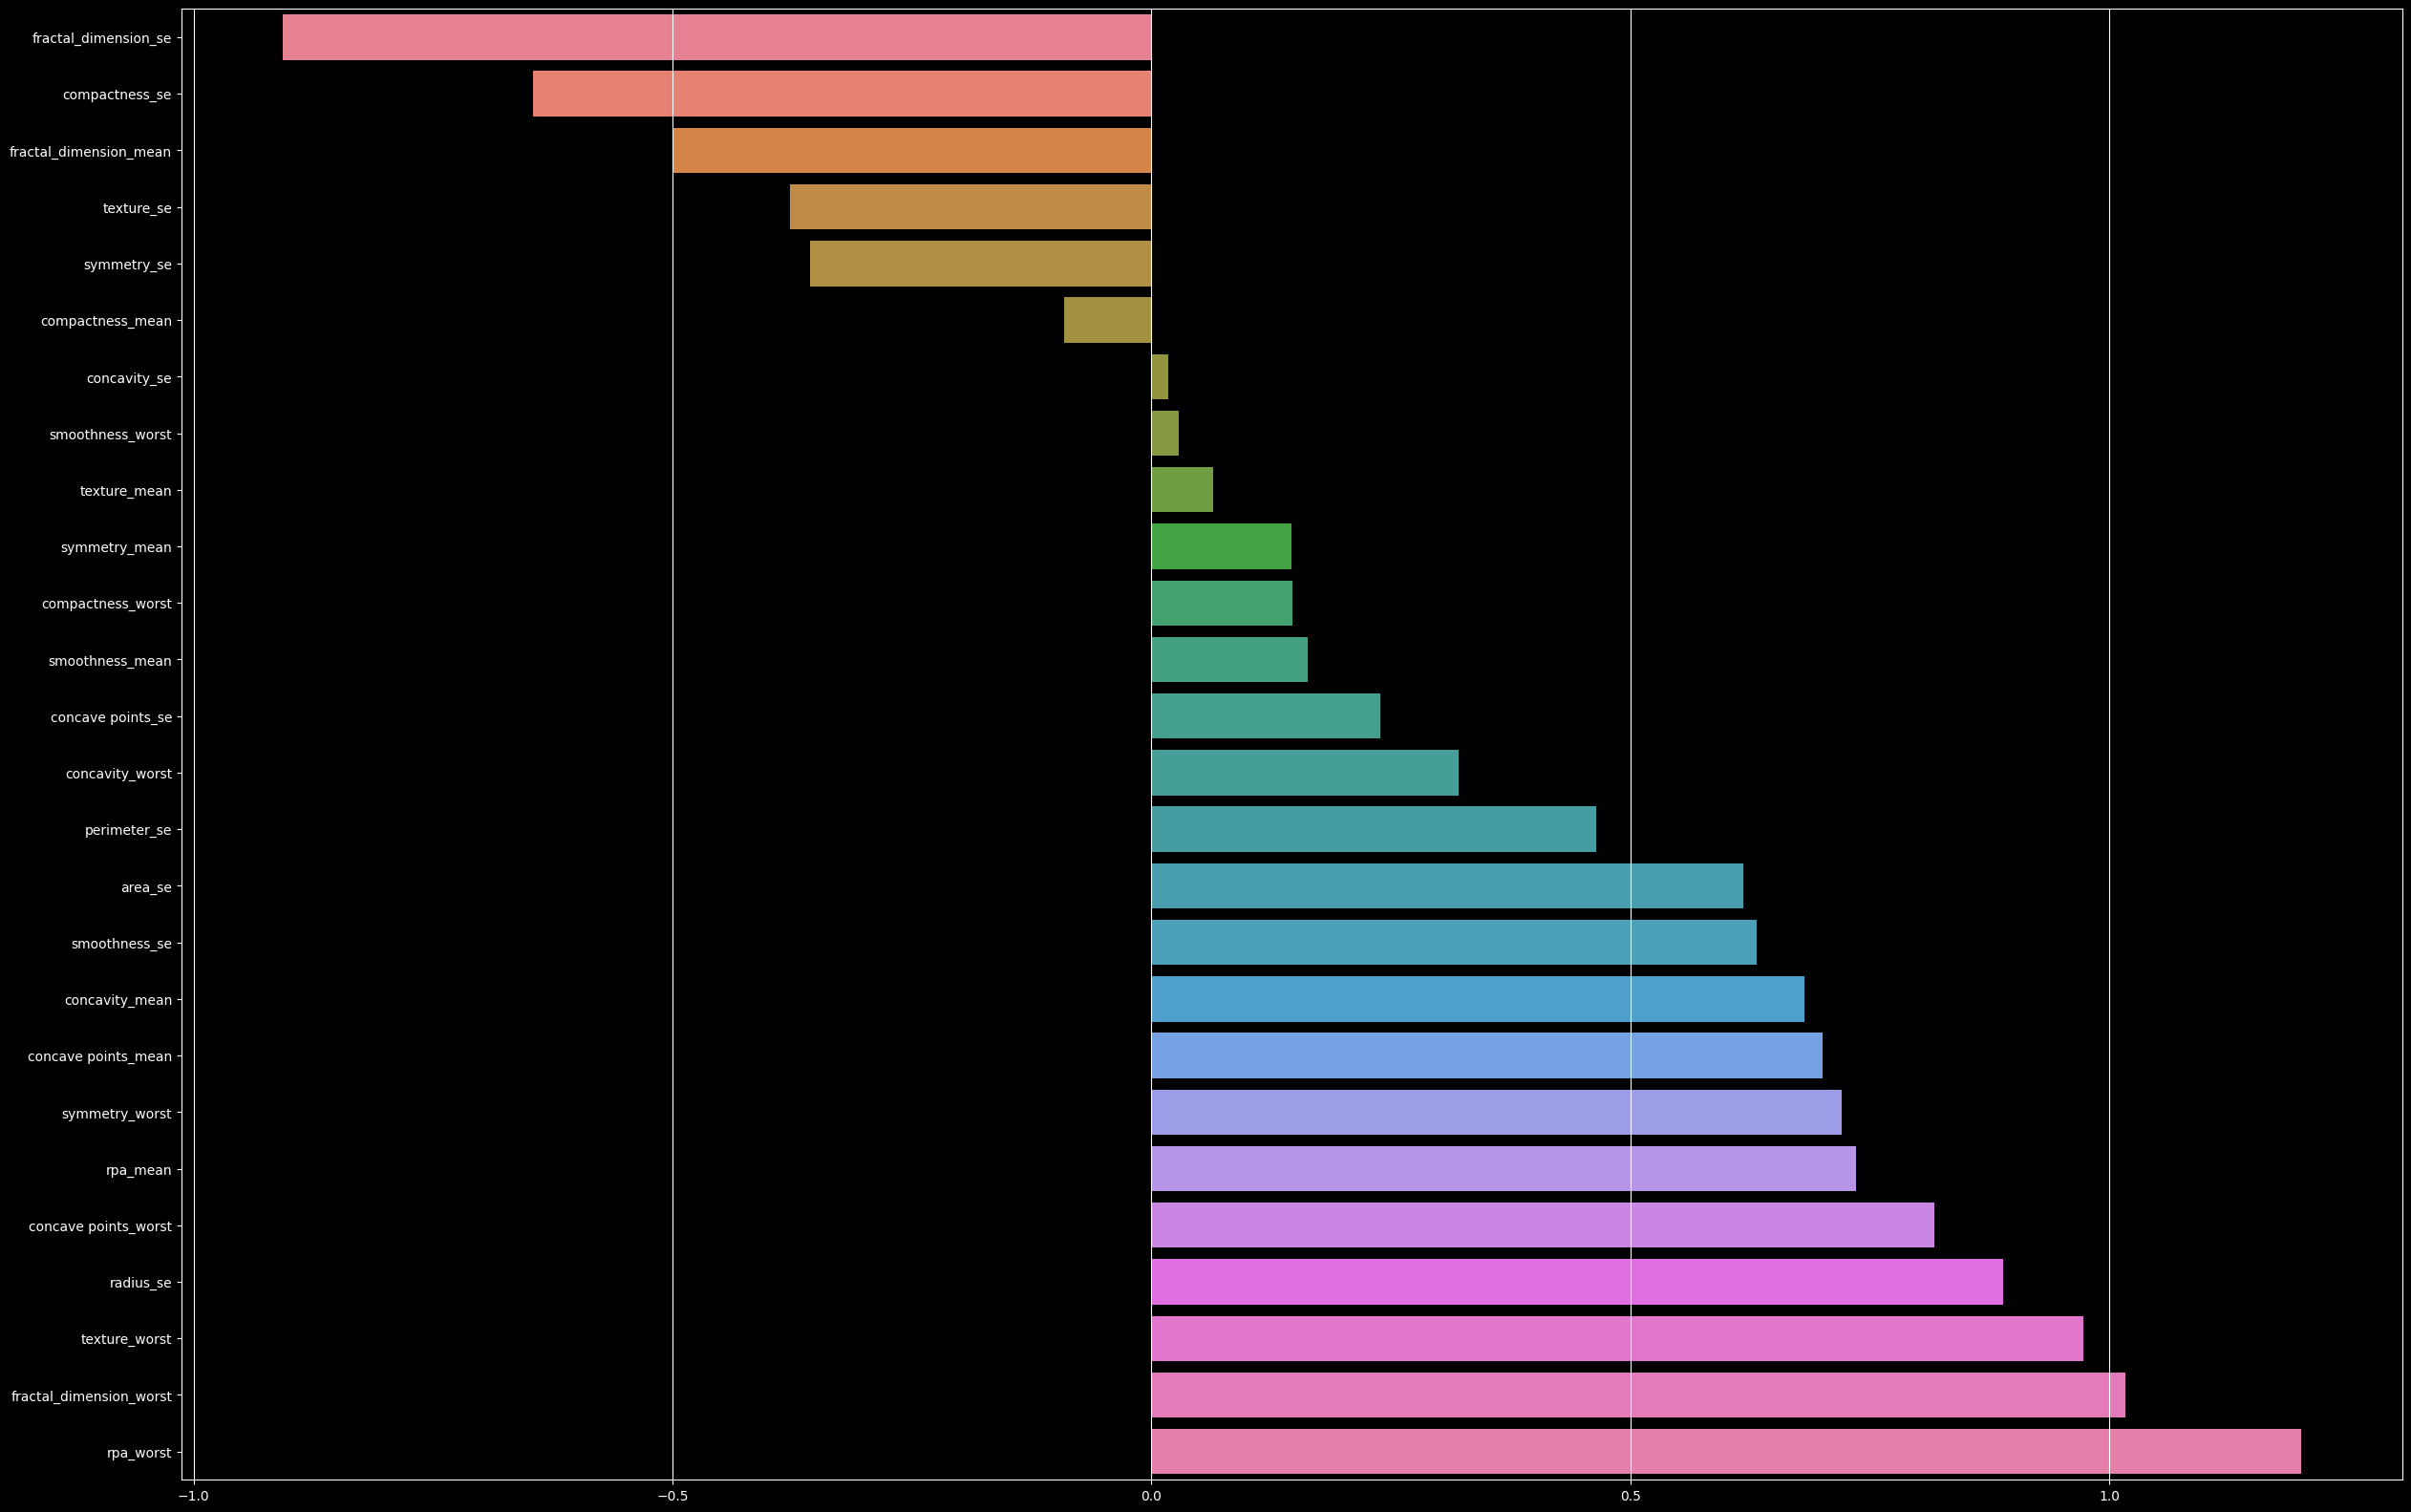

In [50]:
plt.figure(figsize=(30,20))
sns.barplot(data=svm_betas.sort_values(by=0, axis=1), orient="h")
plt.grid(axis="x", c="white")
plt.show()

## XGBoost

In [51]:
from xgboost import XGBClassifier

In [52]:
xgbc = XGBClassifier(max_depth=7, max_leaves=100, n_estimators=50, verbosity=3)

In [53]:
def y_numerical(df_og):
  df = df_og.replace({"B": 0, "M": 1})
  return df

In [54]:
y_train_num = y_numerical(y_train)
y_val_num = y_numerical(y_val)
y_test_num = y_numerical(y_test)

/tmp/ipython-input-1419773918.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df_og.replace({"B": 0, "M": 1})


In [55]:
xgbc.fit(X_train, y_train_num)

[14:30:33] ======== Monitor (0): HostSketchContainer ========
[14:30:33] AllReduce: 0.000561s, 1 calls @ 561us

[14:30:33] MakeCuts: 0.000891s, 1 calls @ 891us

[14:30:33] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (428, 26, 11128).
[14:30:33] DEBUG: /workspace/src/gbm/gbtree.cc:131: Using tree method: 0
[14:30:34] ======== Monitor (0): GBTree ========
[14:30:34] BoostNewTrees: 1.1618s, 50 calls @ 1161797us

[14:30:34] CommitModel: 4.5e-05s, 50 calls @ 45us

[14:30:34] ======== Monitor (0): HistUpdater ========
[14:30:34] BuildHistogram: 0.447642s, 121 calls @ 447642us

[14:30:34] EvaluateSplits: 0.23433s, 171 calls @ 234330us

[14:30:34] InitData: 0.049474s, 50 calls @ 49474us

[14:30:34] InitRoot: 0.143877s, 50 calls @ 143877us

[14:30:34] LeafPartition: 1.4e-05s, 50 calls @ 14us

[14:30:34] UpdatePosition: 0.293941s, 121 calls @ 293941us

[14:30:34] UpdatePredictionCache: 0.026815s, 50 calls @ 26815us

[14:30:34] UpdateTree: 1.13

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=100, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [56]:
xgbc_y_preds = xgbc.predict(X_val)
xgbc_y_probas = xgbc.predict_proba(X_val)

[14:30:34] DEBUG: /workspace/src/gbm/gbtree.cc:131: Using tree method: 0


In [57]:
def model_evaluation_num(y_val, y_preds, y_probas):

  # Evaluate the model on the validation set
  log_precision = skl.metrics.precision_score(y_val, y_preds, pos_label=0) # Assuming 'M' is the positive class
  log_recall = skl.metrics.recall_score(y_val, y_preds, pos_label=0)
  log_f1 = skl.metrics.f1_score(y_val, y_preds, pos_label=0)
  log_bceloss = skl.metrics.log_loss(y_val, y_probas)

  print(f"Validation Precision: {log_precision:.4f}")
  print(f"Validation Recall: {log_recall:.4f}")
  print(f"Validation F1-score: {log_f1:.4f}")
  print(f"Validation BinaryCrossEntropy Loss: {log_bceloss:.4f}")

  # Display confusion matrix
  log_conf_matrix = skl.metrics.confusion_matrix(y_val, y_preds, labels=[1, 0])
  print("\nConfusion Matrix:")
  print(log_conf_matrix) # Specify labels to ensure correct order

  # Display classification report
  print("\nClassification Report:")
  print(skl.metrics.classification_report(y_val, y_preds))

  return log_conf_matrix

In [58]:
xgb_conf_matrix =  model_evaluation_num(y_val_num, xgbc_y_preds, xgbc_y_probas)

Validation Precision: 1.0000
Validation Recall: 0.9054
Validation F1-score: 0.9504
Validation BinaryCrossEntropy Loss: 0.0945

Confusion Matrix:
[[69  0]
 [ 7 67]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        74
           1       0.91      1.00      0.95        69

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.96      0.95      0.95       143



In [59]:
xgbc_betas = pd.DataFrame(xgbc.feature_importances_, index=X_train.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)

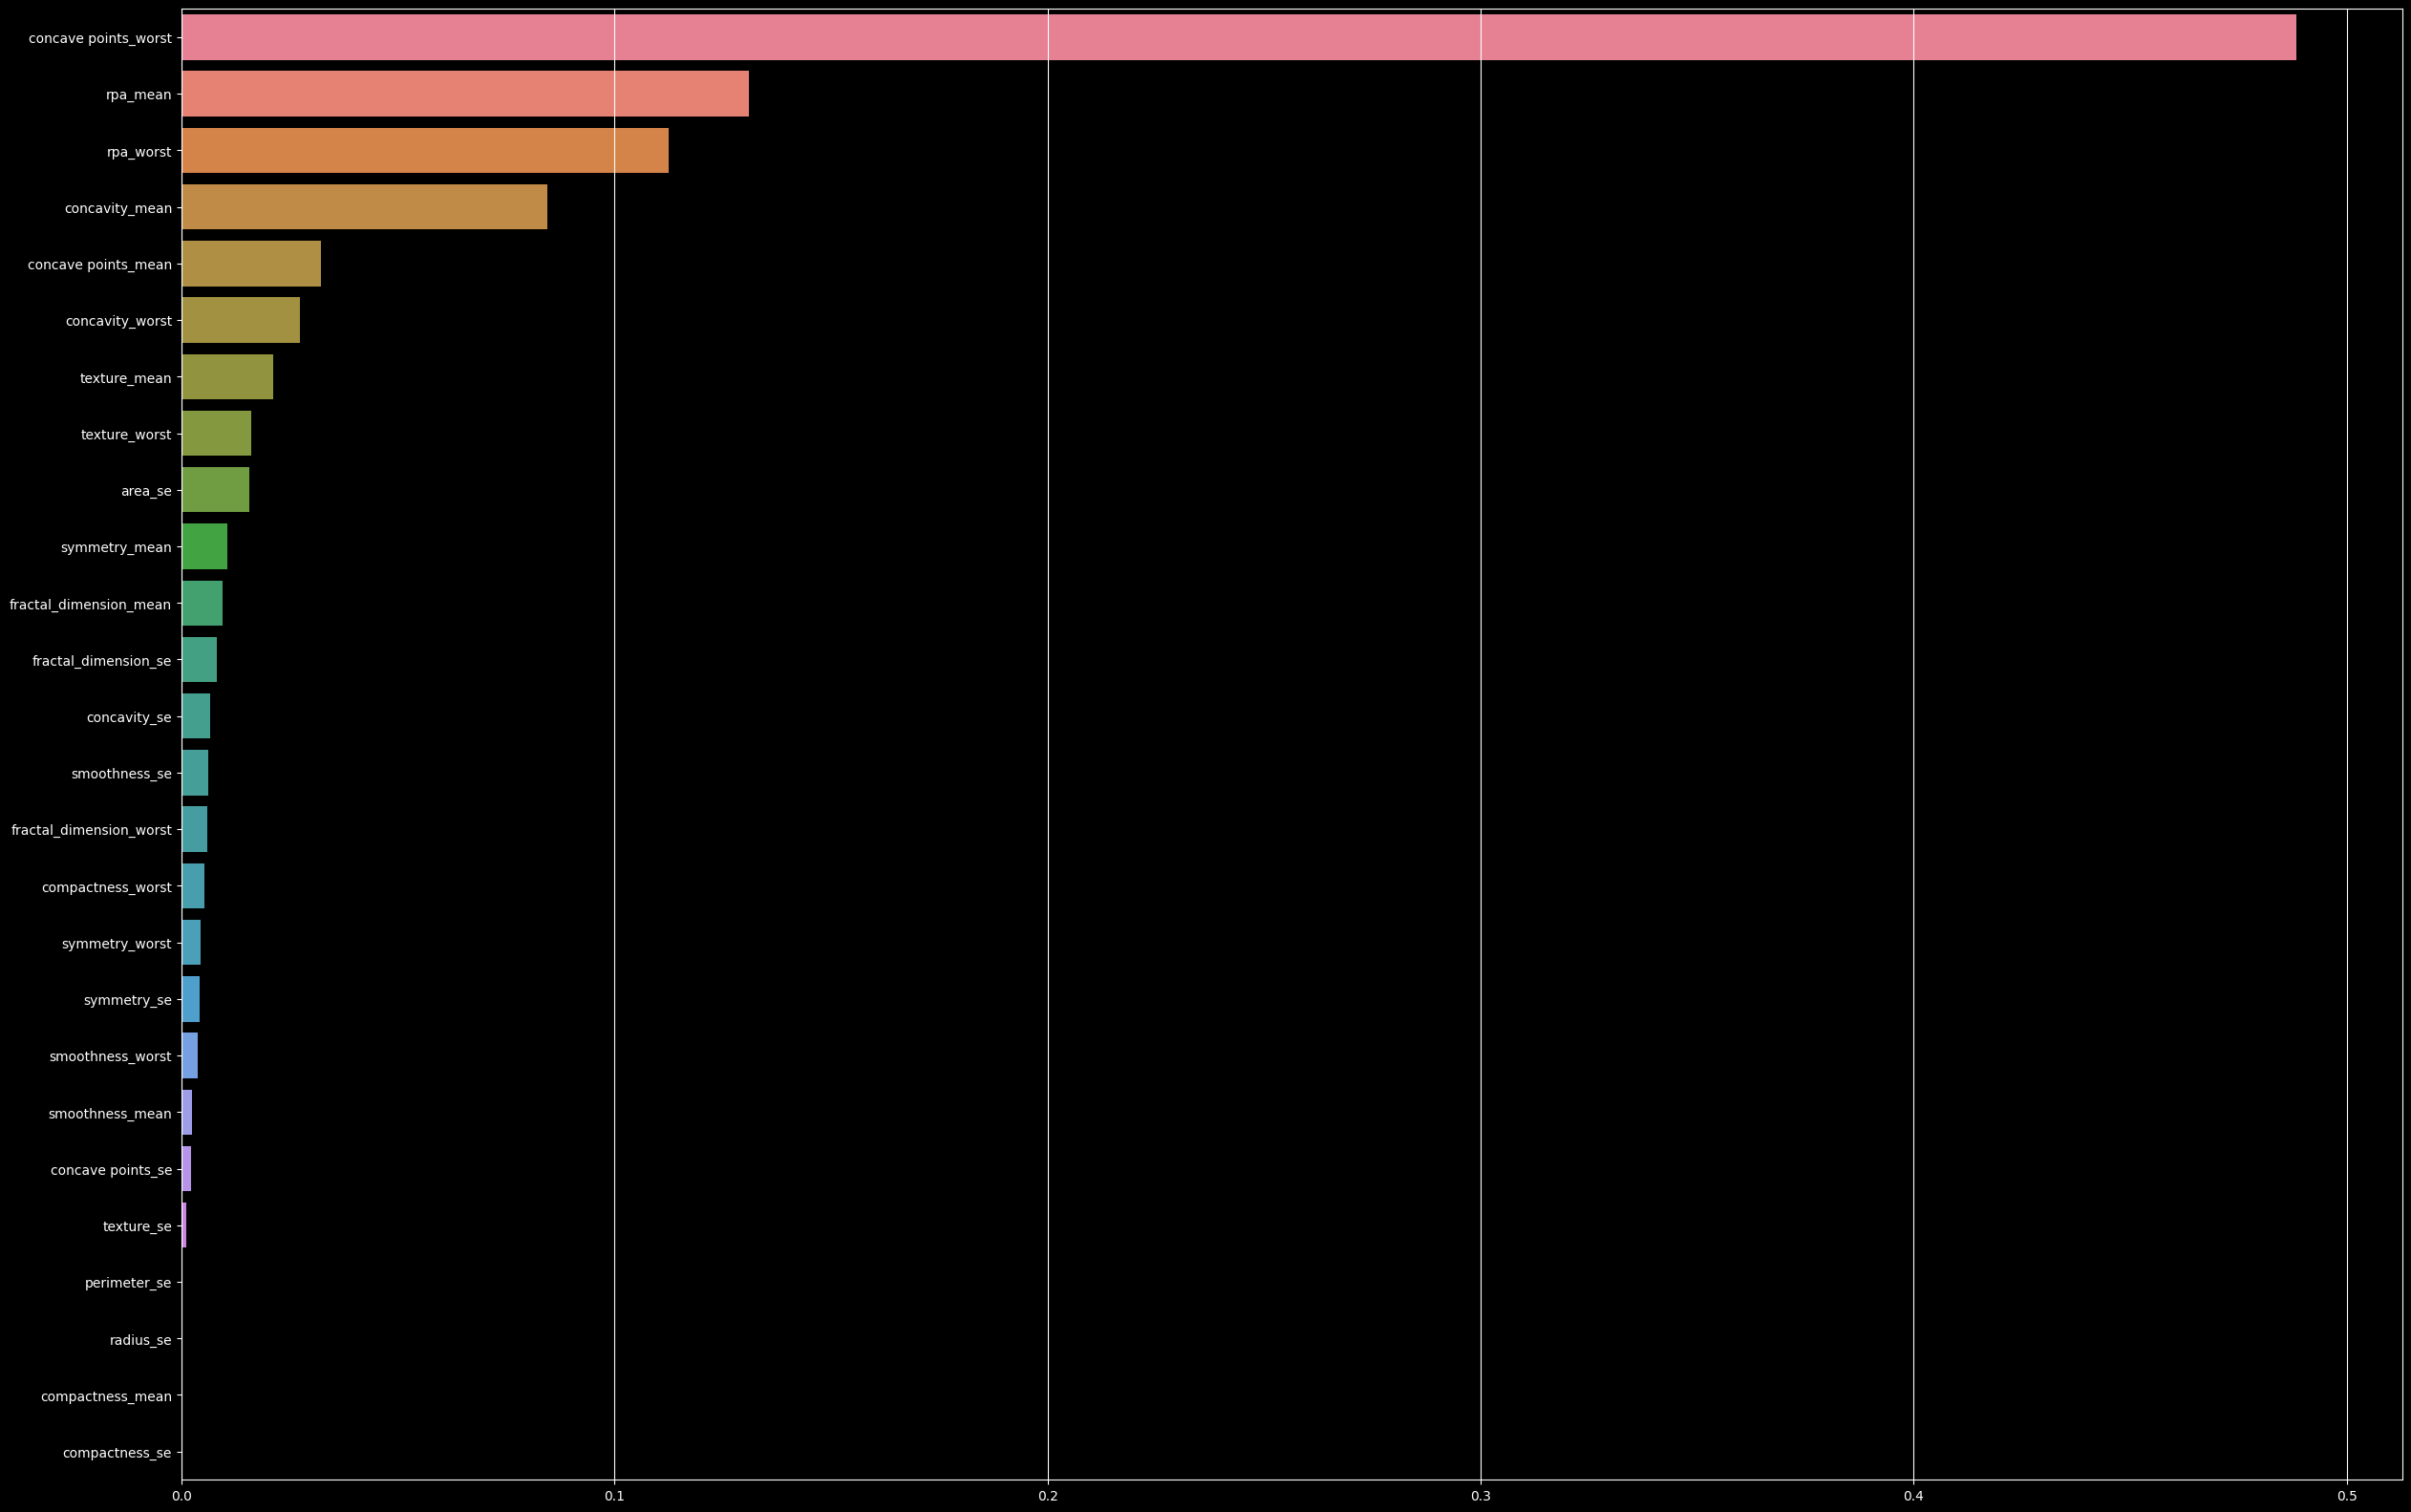

In [60]:
plt.figure(figsize=(30,20))
sns.barplot(data=xgbc_betas.T, orient="h")
plt.grid(axis="x", c="white")
plt.show()

## Neural Networks

In [61]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"We are currently using device: {device}")

We are currently using device: cpu


In [62]:
class CancerDataset(data.Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.values, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)

  def __str__(self) -> str:
    return f"CancerDataset with {len(self)} samples"

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [63]:
train_medium = CancerDataset(X_train, y_train_num)
val_medium = CancerDataset(X_val, y_val_num)
test_medium = CancerDataset(X_test, y_test_num)

In [64]:
train_nn = data.DataLoader(train_medium, batch_size=32, shuffle=True)
val_nn = data.DataLoader(val_medium, batch_size=32, shuffle=True)
test_nn = data.DataLoader(test_medium, batch_size=32, shuffle=True)

In [65]:
print(len(train_nn), "|", X.shape)

14 | (569, 30)


In [66]:
class BCancerDetector(nn.Module):
  def __init__(self) -> None:
    super(BCancerDetector, self).__init__()

    self.layer_1 = nn.Linear(X_train.shape[1], 64)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.layer_2 = nn.Linear(64, 32)
    self.layer_3 = nn.Linear(32, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.layer_3(x)
    x = self.sigmoid(x)
    return x


In [67]:
summary(BCancerDetector().to(device), (X_train.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,728
              ReLU-2                   [-1, 64]               0
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 1]              33
           Sigmoid-8                    [-1, 1]               0
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [68]:
# Instantiate the model, loss function, and optimizer
model = BCancerDetector().to(device)
criterion = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_nn:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1)) # Add unsqueeze(1) to match shape

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    if (epoch+1) % 10 == 0:
      print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {(running_loss / len(train_medium)):.4f}")

    model.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        for val_inputs, val_labels in val_nn:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels.unsqueeze(1))
            val_running_loss += val_loss.item() * val_inputs.size(0)
        val_epoch_loss = val_running_loss / len(val_medium)
        if (epoch+1) % 10 == 0:
          print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {val_epoch_loss:.4f}")
          print("="*38)

print("Training finished!")

Epoch 10/100 | Training Loss: 0.0558
Epoch 10/100 | Validation Loss: 0.0571
Epoch 20/100 | Training Loss: 0.0214
Epoch 20/100 | Validation Loss: 0.0268
Epoch 30/100 | Training Loss: 0.0167
Epoch 30/100 | Validation Loss: 0.0217
Epoch 40/100 | Training Loss: 0.0139
Epoch 40/100 | Validation Loss: 0.0147
Epoch 50/100 | Training Loss: 0.0080
Epoch 50/100 | Validation Loss: 0.0108
Epoch 60/100 | Training Loss: 0.0078
Epoch 60/100 | Validation Loss: 0.0114
Epoch 70/100 | Training Loss: 0.0135
Epoch 70/100 | Validation Loss: 0.0112
Epoch 80/100 | Training Loss: 0.0021
Epoch 80/100 | Validation Loss: 0.0082
Epoch 90/100 | Training Loss: 0.0032
Epoch 90/100 | Validation Loss: 0.0069
Epoch 100/100 | Training Loss: 0.0044
Epoch 100/100 | Validation Loss: 0.0196
Training finished!


In [69]:
threshold = 0.75

In [70]:
nn_y_preds = []
nn_y_probas = []
nn_y_val = []
with torch.no_grad():
  model.eval()
  for inputs, labels in val_nn:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    nn_y_preds.append((outputs > threshold).cpu().numpy())
    nn_y_probas.append(outputs.cpu().numpy())
    nn_y_val.append(labels.cpu().numpy())

nn_y_preds = np.concatenate(nn_y_preds)
nn_y_probas = np.concatenate(nn_y_probas)
nn_y_val = np.concatenate(nn_y_val)

In [71]:
nn_y_val = nn_y_val.astype(int)

In [72]:
nn_y_val

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1])

In [73]:
nn_y_preds = nn_y_preds.flatten().astype(int)

In [74]:
for value in nn_y_probas.flatten():
  if 0.9 < value < 1:
    print(f"{value:.4f}")

1.0000
0.9130
1.0000
0.9938
1.0000
0.9706
0.9639
1.0000
0.9993
0.9999
1.0000
1.0000
0.9997
1.0000
0.9842


In [75]:
nn_conf_matrix = model_evaluation_num(nn_y_val, nn_y_preds, nn_y_probas)

Validation Precision: 1.0000
Validation Recall: 0.9865
Validation F1-score: 0.9932
Validation BinaryCrossEntropy Loss: 0.0196

Confusion Matrix:
[[69  0]
 [ 1 73]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        74
           1       0.99      1.00      0.99        69

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



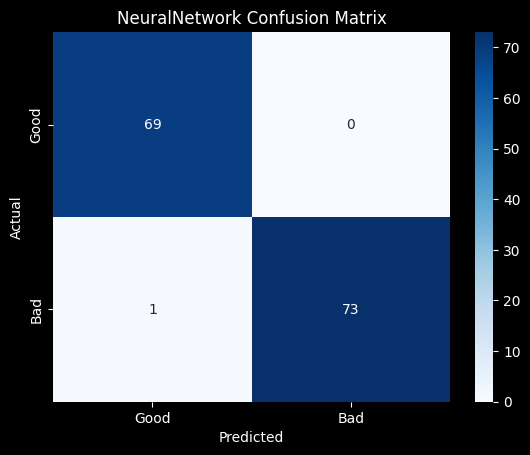

In [76]:
confusion_matrix_heatmap(nn_conf_matrix, "NeuralNetwork Confusion Matrix")

# Testing with Unseen Data
No takebacksies from here, after I evaluate the test set my hands are tied and no more modelling.

In [77]:
X_test

,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,...,fractal_dimension_se,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,rpa_mean,rpa_worst
0,-0.823945,-0.243370,-1.249839,-1.207829,-1.311811,0.211122,-0.076267,-0.868788,-0.442776,-0.922268,...,-0.537106,-0.782481,-0.277700,-1.239268,-1.300368,-1.604394,-0.453546,-0.627140,-1.220482,-1.162830
1,0.400972,-0.281444,0.354382,0.305705,0.722003,1.006945,-1.028845,1.940492,-0.043648,1.779602,...,0.123554,0.366836,0.029231,0.276409,0.261518,0.772027,0.182046,-0.149178,1.326744,1.632175
2,-0.337270,-0.580064,-1.494072,-1.007455,-0.718891,-1.380524,-0.595576,-0.968729,2.063167,-1.020212,...,-0.917709,-0.608494,-1.699060,-1.511546,-1.278305,-1.209000,-1.587481,-1.313931,-0.561151,-0.811901
3,-0.537112,-0.673382,-1.186394,-0.978886,-0.924483,-0.870283,-0.518755,-0.939690,0.628856,-0.920688,...,-0.971884,1.651663,0.480599,-0.763572,-0.625906,-0.655418,0.023557,-0.433945,-0.961531,-0.836129
4,-0.259684,0.739090,0.020252,-0.795576,-0.661685,-0.405736,0.101957,-0.908765,-1.099242,-0.876456,...,-0.913118,-0.215350,1.252439,0.204841,-0.211677,0.181640,0.914039,0.079752,-0.432566,-0.414780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,-1.225981,0.017176,0.801877,-0.226126,-0.731631,0.275854,4.193433,0.322205,-0.652000,0.031891,...,8.334749,-1.802981,-0.629767,-0.238746,-0.811155,-1.243101,-1.151227,1.294200,-1.512038,-1.399720
139,0.792160,0.280273,1.241270,0.662948,0.612604,-0.424996,0.313046,-0.518882,-0.241607,0.192868,...,0.131514,0.336873,-0.140904,0.844835,0.576189,0.536536,-0.080381,-0.080567,-0.042476,-0.204691
140,-0.052788,-0.531538,-0.992480,-0.581370,-0.590239,-0.881707,-0.890568,0.109123,-0.114726,0.018200,...,-0.875930,0.572609,0.245887,-0.812573,-0.216590,-0.219463,-0.121862,-0.642774,-0.443746,0.049594
141,-1.209523,0.091085,-0.421476,-0.875726,-0.940221,-0.748435,1.159011,-0.387564,2.367525,-0.375681,...,1.369121,-1.165587,0.060826,-0.754546,-1.163864,-1.350062,-0.857122,-0.019078,-1.217098,-1.204724


In [78]:
log_test_preds = logistician.predict(X_test)
log_test_probas = logistician.predict_proba(X_test)

In [79]:
# Convert Logistic Regression predictions from strings ('B', 'M') to integers (0, 1)
log_test_preds_num = np.where(log_test_preds == 'B', 0, 1)

log_test_confusion = model_evaluation_num(y_test_num, log_test_preds_num, log_test_probas)

Validation Precision: 0.9600
Validation Recall: 0.9600
Validation F1-score: 0.9600
Validation BinaryCrossEntropy Loss: 0.1744

Confusion Matrix:
[[65  3]
 [ 3 72]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        75
           1       0.96      0.96      0.96        68

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



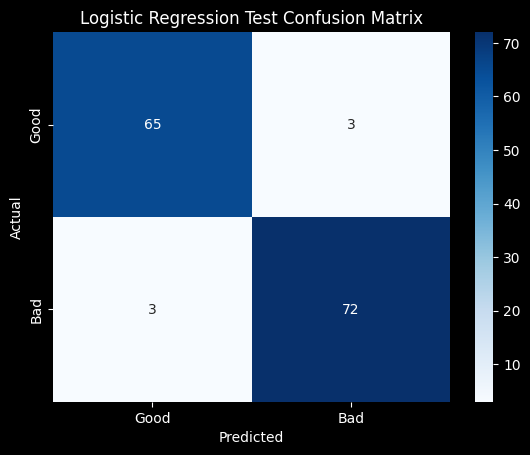

In [80]:
confusion_matrix_heatmap(log_test_confusion, "Logistic Regression Test Confusion Matrix")

In [81]:
forest_test_preds = forest.predict(X_test)
forest_test_probas = forest.predict_proba(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [82]:
def change_to_numerical(y_preds):
  y_preds_num = np.where(y_preds == 'B', 0, 1)
  return y_preds_num

In [83]:
forest_test_preds_num = change_to_numerical(forest_test_preds)

forest_test_confusion = model_evaluation_num(y_test_num, forest_test_preds_num, forest_test_probas)

Validation Precision: 0.9600
Validation Recall: 0.9600
Validation F1-score: 0.9600
Validation BinaryCrossEntropy Loss: 0.1482

Confusion Matrix:
[[65  3]
 [ 3 72]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        75
           1       0.96      0.96      0.96        68

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



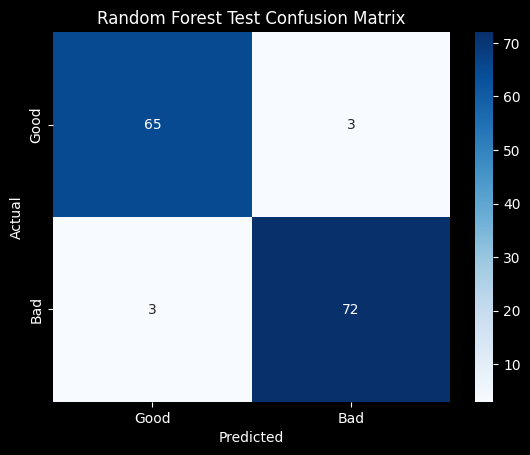

In [84]:
confusion_matrix_heatmap(forest_test_confusion, "Random Forest Test Confusion Matrix")

In [85]:
svm_test_preds = svm.predict(X_test)
svm_test_probas = svm.predict_proba(X_test)

In [86]:
svm_test_preds_num = change_to_numerical(svm_test_preds)

svm_test_confusion = model_evaluation_num(y_test_num, svm_test_preds_num, svm_test_probas)

Validation Precision: 0.9359
Validation Recall: 0.9733
Validation F1-score: 0.9542
Validation BinaryCrossEntropy Loss: 0.1212

Confusion Matrix:
[[63  5]
 [ 2 73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        75
           1       0.97      0.93      0.95        68

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



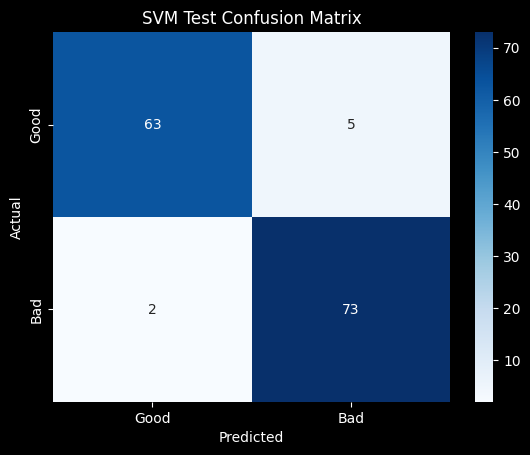

In [87]:
confusion_matrix_heatmap(svm_test_confusion, "SVM Test Confusion Matrix")

In [88]:
xgbc_test_preds = xgbc.predict(X_test)
xgbc_test_probas = xgbc.predict_proba(X_test)

In [89]:
xgbc_test_confusion = xgbc_test_confusion = model_evaluation_num(y_test_num, xgbc_test_preds, xgbc_test_probas)

Validation Precision: 0.9605
Validation Recall: 0.9733
Validation F1-score: 0.9669
Validation BinaryCrossEntropy Loss: 0.1256

Confusion Matrix:
[[65  3]
 [ 2 73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        75
           1       0.97      0.96      0.96        68

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143



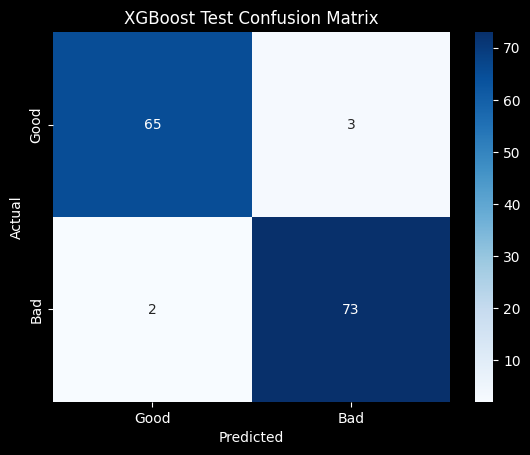

In [90]:
confusion_matrix_heatmap(xgbc_test_confusion, "XGBoost Test Confusion Matrix")

In [91]:
nn_test_preds = []
nn_test_probas = []
nn_y_test = [] # Variable to store the true labels from the test set

with torch.no_grad():
  model.eval()
  for inputs, labels in test_nn: # Use test_nn DataLoader
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    nn_test_preds.append((outputs > threshold).cpu().numpy()) # Use the threshold determined from validation
    nn_test_probas.append(outputs.cpu().numpy())
    nn_y_test.append(labels.cpu().numpy()) # Collect true labels from the test set

nn_test_preds = np.concatenate(nn_test_preds)
nn_test_probas = np.concatenate(nn_test_probas)
nn_y_test = np.concatenate(nn_y_test)

In [92]:
nn_y_test = nn_y_test.astype(int) # Ensure true labels are integers
nn_test_preds_int = nn_test_preds.flatten().astype(int) # Ensure predictions are integers

nn_test_confusion = model_evaluation_num(nn_y_test, nn_test_preds_int, nn_test_probas)

Validation Precision: 0.9605
Validation Recall: 0.9733
Validation F1-score: 0.9669
Validation BinaryCrossEntropy Loss: 0.2562

Confusion Matrix:
[[65  3]
 [ 2 73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        75
           1       0.97      0.96      0.96        68

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143



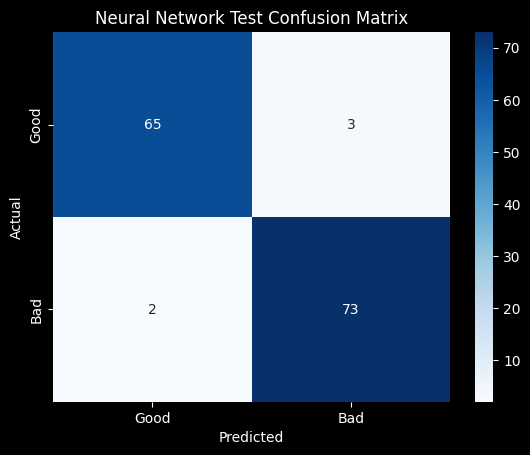

In [93]:
confusion_matrix_heatmap(nn_test_confusion, "Neural Network Test Confusion Matrix")

# Conclusion
Basically Tree models did bad on the validation set, but they are surprisingly good at extrapolating and predicting new data!

The worst performer was the Support Vector Machine here, probably due to overfitting to the training and validation data a bit...

Logistic Regression and the Random Forest surprisingly had the same confusion matrix...

Neural Network had a much higher BCELoss than any of them, even though it had over 3000 learnable parameters.

Just use Random Forests for everything, it gets the job done and it's interpretable enough!

In [97]:
eval_metrics = pd.DataFrame({
    "Precision": [0.9600, 0.9600, 0.9359, 0.9605, 0.9605],
    "Recall": [0.9600, 0.9600, 0.9733, 0.9733, 0.9733],
    "F1-Score": [0.9600, 0.9600, 0.9542, 0.9669, 0.9669],
    "BCE Loss": [0.1744, 0.1482, 0.1212, 0.1256, 0.2562]
}, index=["Logistic Regression", "Random Forest", "SVM", "XGBoost", "Neural Network"])

display(eval_metrics)

,Precision,Recall,F1-Score,BCE Loss
Logistic Regression,0.9600,0.9600,0.9600,0.1744
Random Forest,0.9600,0.9600,0.9600,0.1482
SVM,0.9359,0.9733,0.9542,0.1212
XGBoost,0.9605,0.9733,0.9669,0.1256
Neural Network,0.9605,0.9733,0.9669,0.2562


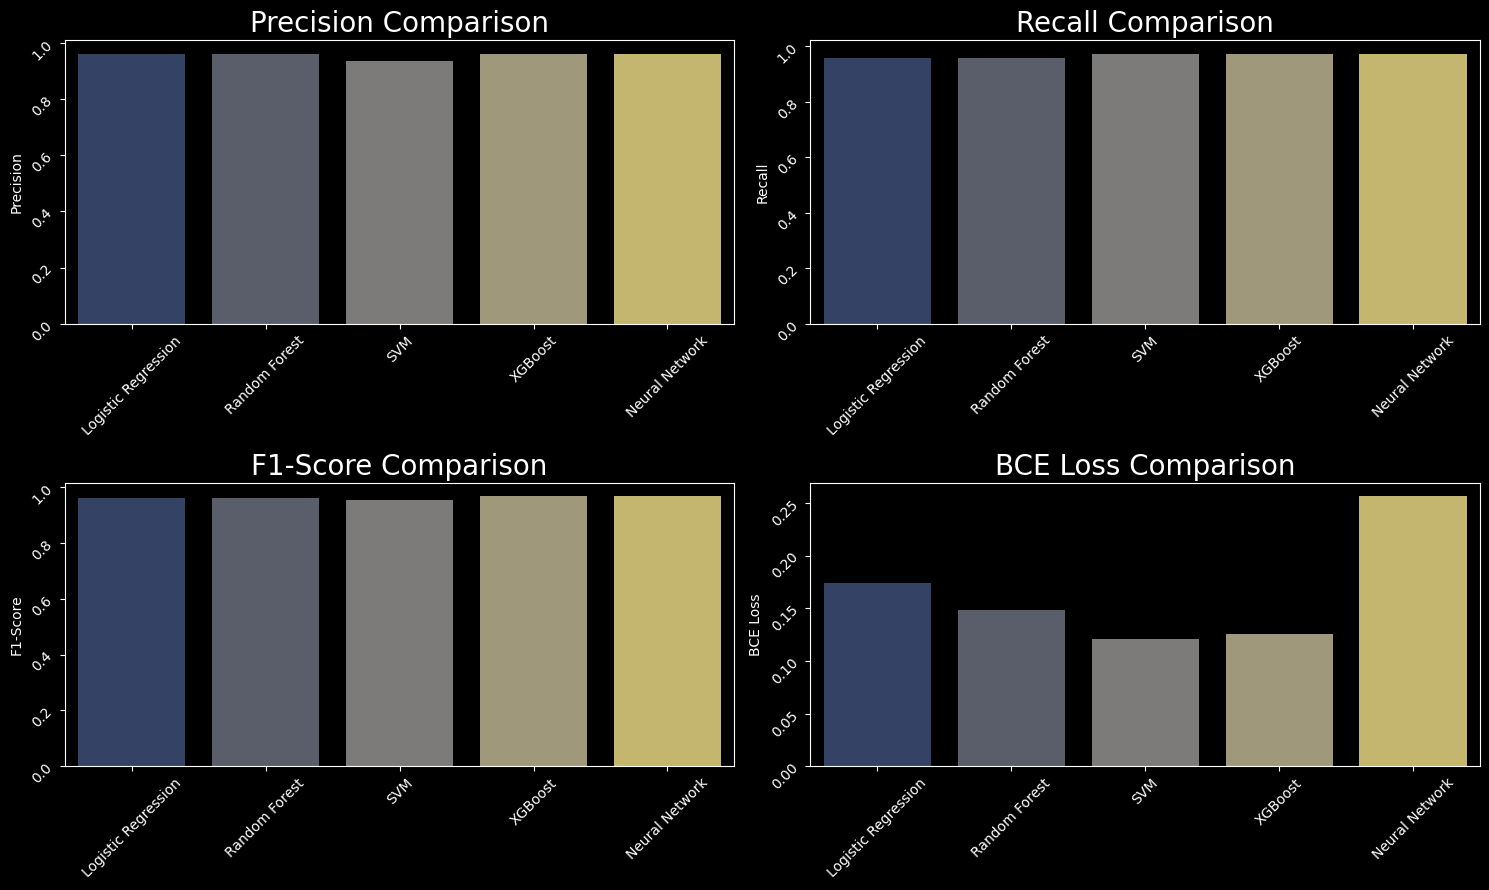

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(15,9))
axes = axes.flatten()

for idx, column in enumerate(list(eval_metrics.columns)):
  sns.barplot(data=eval_metrics, x=eval_metrics.index, y=column, ax=axes[idx], palette="cividis", hue=eval_metrics.index)
  axes[idx].set_xlabel("")
  axes[idx].set_title(f"{column} Comparison", size=20)
  axes[idx].tick_params(rotation=45)

plt.tight_layout()
plt.show()